# exp05: AirREGI 翌日入電予測（Optuna最適化版）

**exp03との違い**: 全モデルをOptuna（50 trials）でハイパーパラメータ最適化

- ベースライン: exp03
- 特徴量: exp03と完全に同じ
- モデル: Ridge, RandomForest, ExtraTrees, GradientBoosting, HistGradientBoosting, XGBoost, LightGBM, CatBoost
- **変更点**: 全モデルにOptuna最適化を適用（trial=50）
- **追加機能**: 各モデルの特徴量重要度を可視化

## 重要な原則（exp03から継承）
1. 未来のデータを使わない（ラグ特徴量は過去のデータのみ）
2. 移動平均も過去のデータのみを使用
3. 訓練データとテストデータは時系列で分割

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ==================================================================================
# Step 1: データの読み込みと前処理
# ==================================================================================

def load_and_preprocess_data():
    """
    各データセットを読み込み、日付型に変換
    """
    print("=" * 80)
    print("Step 1: データの読み込み")
    print("=" * 80)
    
    # データ読み込み
    calender = pd.read_csv('../input/calender_data.csv')
    cm_data = pd.read_csv('../input/cm_data.csv')
    gt_service = pd.read_csv('../input/gt_service_name.csv')
    acc_get = pd.read_csv('../input/regi_acc_get_data_transform.csv')
    call_data = pd.read_csv('../input/regi_call_data_transform.csv')
    
    # 日付カラムをdatetime型に変換
    calender['cdr_date'] = pd.to_datetime(calender['cdr_date'])
    cm_data['cdr_date'] = pd.to_datetime(cm_data['cdr_date'])
    acc_get['cdr_date'] = pd.to_datetime(acc_get['cdr_date'])
    call_data['cdr_date'] = pd.to_datetime(call_data['cdr_date'])
    gt_service['week'] = pd.to_datetime(gt_service['week'])
    
    print(f"\nカレンダーデータ: {calender.shape}")
    print(f"CMデータ: {cm_data.shape}")
    print(f"Google Trendsデータ: {gt_service.shape}")
    print(f"アカウント取得データ: {acc_get.shape}")
    print(f"入電データ（目的変数）: {call_data.shape}")
    
    return calender, cm_data, gt_service, acc_get, call_data

In [3]:
# ==================================================================================
# Step 2: データの統合
# ==================================================================================

def merge_datasets(calender, cm_data, gt_service, acc_get, call_data):
    """
    全てのデータセットを統合
    Google Trendsは週次データなので日次に展開
    """
    print("\n" + "=" * 80)
    print("Step 2: データの統合")
    print("=" * 80)
    
    # メインデータ（入電数）を基準にマージ
    df = call_data.copy()
    print(f"\nベースデータ: {df.shape}")
    
    # カレンダー情報をマージ
    df = df.merge(calender, on='cdr_date', how='left')
    print(f"カレンダー情報マージ後: {df.shape}")
    
    # CM情報をマージ
    df = df.merge(cm_data, on='cdr_date', how='left')
    print(f"CM情報マージ後: {df.shape}")
    
    # アカウント取得数をマージ
    df = df.merge(acc_get, on='cdr_date', how='left')
    print(f"アカウント取得数マージ後: {df.shape}")
    
    # Google Trendsデータは週次なので日次に展開
    print("\nGoogle Trendsデータを週次→日次に展開...")
    gt_service_daily = []
    for idx, row in gt_service.iterrows():
        week_start = row['week']
        for i in range(7):
            date = week_start + timedelta(days=i)
            gt_service_daily.append({
                'cdr_date': date, 
                'search_cnt': row['search_cnt']
            })
    
    gt_daily = pd.DataFrame(gt_service_daily)
    df = df.merge(gt_daily, on='cdr_date', how='left')
    print(f"Google Trendsマージ後: {df.shape}")
    
    # 欠損値の確認
    print("\n欠損値の数:")
    print(df.isnull().sum().sort_values(ascending=False).head(10))
    
    return df

In [4]:
# ==================================================================================
# Step 3: 基本的な時系列特徴量の作成
# ==================================================================================

def create_basic_time_features(df):
    """
    日付から派生する基本的な時系列特徴量を作成
    これらは未来の情報を使わないので安全
    """
    print("\n" + "=" * 80)
    print("Step 3: 基本的な時系列特徴量の作成")
    print("=" * 80)
    
    df = df.copy()
    
    # 年月日の特徴量
    df['year'] = df['cdr_date'].dt.year
    df['month'] = df['cdr_date'].dt.month
    df['day_of_month'] = df['cdr_date'].dt.day
    df['quarter'] = df['cdr_date'].dt.quarter
    df['day_of_year'] = df['cdr_date'].dt.dayofyear
    
    # 週の情報（既にwoy, womがあるが念のため）
    df['week_of_year'] = df['cdr_date'].dt.isocalendar().week
    
    # 経過日数（データの開始日からの日数）
    df['days_from_start'] = (df['cdr_date'] - df['cdr_date'].min()).dt.days
    
    # 曜日情報（既にdowがあるが確認）
    # dow: 1=月, 2=火, ..., 7=日
    
    # 月初・月末フラグ
    df['is_month_start'] = (df['day_of_month'] <= 5).astype(int)
    df['is_month_end'] = (df['day_of_month'] >= 25).astype(int)
    
    print("\n作成した基本特徴量:")
    time_features = ['year', 'month', 'day_of_month', 'quarter', 'day_of_year', 
                     'week_of_year', 'days_from_start', 'is_month_start', 'is_month_end']
    print(time_features)
    
    return df

In [5]:
# ==================================================================================
# Step 4: ラグ特徴量の作成（データリーケージに注意！）
# ==================================================================================

def create_lag_features(df, target_col='call_num', lags=[1, 2, 3, 5, 7, 14, 30]):
    """
    ラグ特徴量（過去のデータ）を作成
    
    重要: 
    - shift()を使って、未来の情報が混入しないようにする
    - lag=1は1日前のデータ、lag=7は7日前のデータ
    
    例: 
    日付        call_num    lag_1    lag_7
    2018-06-01    183        NaN      NaN
    2018-06-02      0        183      NaN
    2018-06-08     96         0       183  <- 7日前のデータ
    """
    print("\n" + "=" * 80)
    print("Step 4: ラグ特徴量の作成（データリーケージ防止）")
    print("=" * 80)
    
    df = df.copy()
    
    print(f"\n目的変数: {target_col}")
    print(f"作成するラグ: {lags}")
    
    for lag in lags:
        col_name = f'lag_{lag}'
        df[col_name] = df[target_col].shift(lag)
        print(f"  作成: {col_name} (shift={lag})")
    
    # 最初のN日はラグ特徴量がNaNになる
    print(f"\n注意: 最初の{max(lags)}日間はラグ特徴量がNaNになります")
    print(f"例: lag_30は最初の30日間がNaN")
    
    return df

In [6]:
# ==================================================================================
# Step 5: 移動平均特徴量の作成（データリーケージに注意！）
# ==================================================================================

def create_rolling_features(df, target_col='call_num', windows=[3, 7, 14, 30]):
    """
    移動平均・移動標準偏差を作成
    
    重要:
    - rolling().mean() を使う前に shift(1) を適用
    - これにより、当日のデータが移動平均に含まれない（リーケージ防止）
    
    例（window=3の場合）:
    日付        call_num    過去3日の平均
    2018-06-01    183        NaN
    2018-06-02      0        NaN
    2018-06-03      0        NaN
    2018-06-04    213        61.0  <- (183+0+0)/3 = 61.0
    """
    print("\n" + "=" * 80)
    print("Step 5: 移動平均特徴量の作成（データリーケージ防止）")
    print("=" * 80)
    
    df = df.copy()
    
    print(f"\n目的変数: {target_col}")
    print(f"移動平均ウィンドウ: {windows}")
    
    for window in windows:
        # 移動平均（当日を含まない＝shift(1)してからrolling）
        ma_col = f'ma_{window}'
        df[ma_col] = df[target_col].shift(1).rolling(window=window, min_periods=1).mean()
        print(f"  作成: {ma_col} (過去{window}日間の平均)")
        
        # 移動標準偏差（変動の大きさを捉える）
        std_col = f'ma_std_{window}'
        df[std_col] = df[target_col].shift(1).rolling(window=window, min_periods=1).std()
        print(f"  作成: {std_col} (過去{window}日間の標準偏差)")
    
    print("\nなぜshift(1)が必要か:")
    print("  × 悪い例: rolling(3).mean() → 当日含む3日間の平均（リーケージ！）")
    print("  ○ 良い例: shift(1).rolling(3).mean() → 過去3日間の平均（安全）")
    
    return df

In [7]:
# ==================================================================================
# Step 6: その他の集約特徴量
# ==================================================================================

def create_aggregated_features(df):
    """
    その他の有用な集約特徴量を作成
    """
    print("\n" + "=" * 80)
    print("Step 6: その他の集約特徴量")
    print("=" * 80)
    
    df = df.copy()
    
    # CM効果の累積（過去7日間のCM実施回数）
    # これも当日を含まないようにshift(1)
    df['cm_7d'] = df['cm_flg'].shift(1).rolling(window=7, min_periods=1).sum()
    print("  作成: cm_7d (過去7日間のCM実施回数)")
    
    # Google Trendsの移動平均（ノイズ除去）
    df['gt_ma_7'] = df['search_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    print("  作成: gt_ma_7 (過去7日間のGoogle Trends平均)")
    
    # アカウント取得数の移動平均
    df['acc_ma_7'] = df['acc_get_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    print("  作成: acc_ma_7 (過去7日間のアカウント取得平均)")
    
    # 曜日ごとの過去平均（同じ曜日の過去データの平均）
    # これは少し高度だが、曜日パターンを捉えるのに有効
    print("\n  作成中: dow_avg (同じ曜日の過去平均)...")
    df['dow_avg'] = np.nan
    for dow in df['dow'].unique():
        mask = df['dow'] == dow
        # 各行について、その行より前のデータの平均を計算
        df.loc[mask, 'dow_avg'] = df.loc[mask, 'call_num'].shift(1).expanding().mean()
    
    return df

In [8]:
# ==================================================================================
# Step 7: 特徴量の選択とデータ分割（翌日予測に変更）
# ==================================================================================

def select_features_and_split(df, test_months=3):
    """
    特徴量を選択し、訓練データとテストデータに分割
    
    重要: 時系列データは時間順に分割する
    **exp03変更点**: 目的変数を call_num.shift(-1) に変更（翌日予測）
    """
    print("\n" + "=" * 80)
    print("Step 7: 特徴量選択とデータ分割")
    print("=" * 80)
    
    # 🚨 exp03変更点: 翌日の入電数を目的変数にする
    df = df.copy()
    df['target_next_day'] = df['call_num'].shift(-1)
    print("\n🎯 exp05: 目的変数を翌日の入電数に設定 (call_num.shift(-1))")
    
    # 最後の行はtargetがNaNになるので削除
    df = df.dropna(subset=['target_next_day']).reset_index(drop=True)
    print(f"翌日データがない最終行を削除: {len(df)}行")
    
    # 平日のみを使用（土日は入電数が0なので予測不要）
    df_model = df[df['dow'].isin([1, 2, 3, 4, 5])].copy().reset_index(drop=True)
    print(f"\n平日のみに絞り込み: {len(df)} → {len(df_model)}行")
    
    # 特徴量リスト（exp01と同じ）
    feature_cols = [
        # 基本的な時系列特徴量
        'dow', 'day_of_month', 'month', 'quarter', 'year', 
        'days_from_start', 'day_of_year', 'week_of_year',
        'is_month_start', 'is_month_end',
        
        # カレンダー特徴量
        'woy', 'wom', 'day_before_holiday_flag',
        
        # 外部データ
        'cm_flg', 'acc_get_cnt', 'search_cnt',
        
        # 集約特徴量
        'cm_7d', 'gt_ma_7', 'acc_ma_7', 'dow_avg',
        
        # ラグ特徴量
        'lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_7', 'lag_14', 'lag_30',
        
        # 移動平均特徴量
        'ma_3', 'ma_7', 'ma_14', 'ma_30',
        'ma_std_3', 'ma_std_7', 'ma_std_14', 'ma_std_30'
    ]
    
    print(f"\n使用する特徴量数: {len(feature_cols)}")
    print("\n特徴量のカテゴリ:")
    print(f"  - 基本時系列: 10個")
    print(f"  - カレンダー: 3個")
    print(f"  - 外部データ: 3個")
    print(f"  - 集約特徴量: 4個")
    print(f"  - ラグ特徴量: 7個")
    print(f"  - 移動平均: 8個")
    
    # 時系列分割（最後の3ヶ月をテストデータ）
    split_date = df_model['cdr_date'].max() - pd.Timedelta(days=30*test_months)
    
    train_df = df_model[df_model['cdr_date'] < split_date].copy()
    test_df = df_model[df_model['cdr_date'] >= split_date].copy()
    
    print(f"\n時系列分割:")
    print(f"  訓練データ期間: {train_df['cdr_date'].min()} ~ {train_df['cdr_date'].max()}")
    print(f"  テストデータ期間: {test_df['cdr_date'].min()} ~ {test_df['cdr_date'].max()}")
    print(f"  訓練データ数: {len(train_df)}行")
    print(f"  テストデータ数: {len(test_df)}行")
    
    # 欠損値がある行を削除（ラグ特徴量の初期値等）
    train_clean = train_df.dropna(subset=feature_cols + ['target_next_day'])
    test_clean = test_df.dropna(subset=feature_cols + ['target_next_day'])
    
    print(f"\n欠損値除去後:")
    print(f"  訓練データ数: {len(train_clean)}行")
    print(f"  テストデータ数: {len(test_clean)}行")
    
    # X（特徴量）とy（目的変数）に分割
    X_train = train_clean[feature_cols]
    y_train = train_clean['target_next_day']  # 🚨 exp05: 翌日の値
    X_test = test_clean[feature_cols]
    y_test = test_clean['target_next_day']    # 🚨 exp05: 翌日の値
    
    # メタ情報も保存（日付など）
    train_meta = train_clean[['cdr_date', 'call_num', 'target_next_day']]
    test_meta = test_clean[['cdr_date', 'call_num', 'target_next_day']]
    
    return X_train, X_test, y_train, y_test, train_meta, test_meta, feature_cols

In [9]:
# ==================================================================================
# Step 8: 特徴量の重要度確認用関数
# ==================================================================================

def analyze_features(X_train, y_train, feature_cols):
    """
    特徴量の基本統計と相関を確認
    """
    print("\n" + "=" * 80)
    print("Step 8: 特徴量の分析")
    print("=" * 80)
    
    # 基本統計量
    print("\n特徴量の基本統計:")
    print(X_train.describe().T[['mean', 'std', 'min', 'max']].head(10))
    
    # 目的変数との相関
    print("\n目的変数（翌日入電数）との相関（上位10）:")
    correlations = pd.DataFrame({
        'feature': feature_cols,
        'correlation': [X_train[col].corr(y_train) for col in feature_cols]
    }).sort_values('correlation', ascending=False, key=abs)
    
    print(correlations.head(10))
    
    return correlations

In [10]:
# ==================================================================================
# メイン実行関数
# ==================================================================================

def main():
    """
    全ての処理を実行
    """
    print("\n")
    print("*" * 80)
    print("exp05: AirREGI ヘルプデスク 翌日入電予測 (Optuna最適化版)")
    print("*" * 80)
    
    # Step 1: データ読み込み
    calender, cm_data, gt_service, acc_get, call_data = load_and_preprocess_data()
    
    # Step 2: データ統合
    df = merge_datasets(calender, cm_data, gt_service, acc_get, call_data)
    
    # Step 3: 基本時系列特徴量
    df = create_basic_time_features(df)
    
    # Step 4: ラグ特徴量
    df = create_lag_features(df, target_col='call_num', lags=[1, 2, 3, 5, 7, 14, 30])
    
    # Step 5: 移動平均特徴量
    df = create_rolling_features(df, target_col='call_num', windows=[3, 7, 14, 30])
    
    # Step 6: その他集約特徴量
    df = create_aggregated_features(df)
    
    # Step 7: 特徴量選択とデータ分割（翌日予測版）
    X_train, X_test, y_train, y_test, train_meta, test_meta, feature_cols = \
        select_features_and_split(df, test_months=3)
    
    # Step 8: 特徴量分析
    correlations = analyze_features(X_train, y_train, feature_cols)
    
    # データ保存
    print("\n" + "=" * 80)
    print("データの保存")
    print("=" * 80)
    
    # output ディレクトリが存在しない場合は作成
    import os
    output_dir = '../output/exp05'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"  {output_dir} ディレクトリを作成しました")
    
    train_data = pd.concat([train_meta.reset_index(drop=True), 
                           X_train.reset_index(drop=True)], axis=1)
    test_data = pd.concat([test_meta.reset_index(drop=True), 
                          X_test.reset_index(drop=True)], axis=1)
    
    train_data.to_csv(f'{output_dir}/train_features.csv', index=False)
    test_data.to_csv(f'{output_dir}/test_features.csv', index=False)
    correlations.to_csv(f'{output_dir}/feature_correlations.csv', index=False)
    
    print("\n保存完了:")
    print(f"  - {output_dir}/train_features.csv")
    print(f"  - {output_dir}/test_features.csv")
    print(f"  - {output_dir}/feature_correlations.csv")
    
    print("\n" + "=" * 80)
    print("特徴量エンジニアリング完了！")
    print("=" * 80)
    print(f"\n訓練データ: {X_train.shape}")
    print(f"テストデータ: {X_test.shape}")
    print(f"特徴量数: {len(feature_cols)}")
    print(f"\n🎯 目的変数: 翌日の入電数 (call_num.shift(-1))")
    
    return df, X_train, X_test, y_train, y_test, feature_cols

In [11]:
# ==================================================================================
# 実行
# ==================================================================================

if __name__ == "__main__":
    df, X_train, X_test, y_train, y_test, feature_cols = main()



********************************************************************************
exp05: AirREGI ヘルプデスク 翌日入電予測 (Optuna最適化版)
********************************************************************************
Step 1: データの読み込み

カレンダーデータ: (670, 10)
CMデータ: (762, 2)
Google Trendsデータ: (109, 2)
アカウント取得データ: (701, 2)
入電データ（目的変数）: (670, 2)

Step 2: データの統合

ベースデータ: (670, 2)
カレンダー情報マージ後: (670, 11)
CM情報マージ後: (670, 12)
アカウント取得数マージ後: (670, 13)

Google Trendsデータを週次→日次に展開...
Google Trendsマージ後: (670, 14)

欠損値の数:
holiday_name               632
cdr_date                     0
call_num                     0
dow                          0
dow_name                     0
woy                          0
wom                          0
doy                          0
financial_year               0
day_before_holiday_flag      0
dtype: int64

Step 3: 基本的な時系列特徴量の作成

作成した基本特徴量:
['year', 'month', 'day_of_month', 'quarter', 'day_of_year', 'week_of_year', 'days_from_start', 'is_month_start', 'is_month_end']

Step 4: ラグ特徴量の

---

# モデル学習セクション（exp01と同じ）

In [12]:
import numpy as np
import pandas as pd
import optuna
from optuna.samplers import TPESampler

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Example features:", feature_cols[:10])

# Optunaのログを抑制
optuna.logging.set_verbosity(optuna.logging.WARNING)

Train: (391, 35) Test: (65, 35)
Example features: ['dow', 'day_of_month', 'month', 'quarter', 'year', 'days_from_start', 'day_of_year', 'week_of_year', 'is_month_start', 'is_month_end']


In [13]:
# =========================
# 1) Metrics helper（WAPE追加版）
# =========================
def evaluate(y_true, y_pred):
    """
    評価指標を計算（MAE, RMSE, R2, WAPE）
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    
    # WAPE (Weighted Absolute Percentage Error)
    wape = (np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))) * 100
    
    return {
        "MAE": mae, 
        "RMSE": rmse, 
        "R2": r2,
        "WAPE": wape
    }

results = []
trained_models = {}  # モデルを保存
optuna_studies = {}  # Optuna studyを保存

def add_result(name, y_pred, model=None, study=None):
    m = evaluate(y_test, y_pred)
    results.append({"Model": name, **m})
    if model is not None:
        trained_models[name] = model
    if study is not None:
        optuna_studies[name] = study
    
print("Metrics functions defined (with WAPE)")

Metrics functions defined (with WAPE)


In [14]:
# =========================
# 2) Baselines
# =========================
test_full = pd.read_csv("../output/exp05/test_features.csv", parse_dates=["cdr_date"])
baseline_current_day = test_full['call_num'].values

# (A) 当日踏襲: y_hat(t+1) = call_num(t)
add_result("Baseline: current_day (今日=明日)", baseline_current_day)

# (B) 先週同曜日踏襲: yhat = lag_7
if "lag_7" in X_test.columns:
    add_result("Baseline: lag_7 (先週同曜日)", X_test["lag_7"].values)

# (C) 過去7日平均: yhat = ma_7
if "ma_7" in X_test.columns:
    add_result("Baseline: ma_7 (過去7日平均)", X_test["ma_7"].values)

# (D) 混合
if "lag_7" in X_test.columns:
    yhat = 0.7 * baseline_current_day + 0.3 * X_test["lag_7"].values
    add_result("Baseline: 0.7*current + 0.3*lag_7", yhat)

print("Baselines calculated")

Baselines calculated


In [15]:
# =========================
# 3) 時系列validation分割（GBDT用）
# =========================
def time_valid_split_from_df(df, valid_days=60):
    """時系列validationデータを作成"""
    TARGET = "target_next_day"
    DROP_COLS = ["cdr_date", "call_num", TARGET]
    
    cutoff = df['cdr_date'].max() - pd.Timedelta(days=valid_days)
    
    tr_df = df[df['cdr_date'] < cutoff].copy()
    va_df = df[df['cdr_date'] >= cutoff].copy()
    
    X_tr = tr_df.drop(columns=DROP_COLS)
    y_tr = tr_df[TARGET].astype(float)
    X_va = va_df.drop(columns=DROP_COLS)
    y_va = va_df[TARGET].astype(float)
    
    return X_tr, y_tr, X_va, y_va

# trainデータを読み込んで分割
train_full = pd.read_csv("../output/exp05/train_features.csv", parse_dates=["cdr_date"])
X_tr, y_tr, X_va, y_va = time_valid_split_from_df(train_full, valid_days=60)
print(f"Training set: {X_tr.shape}, Validation set: {X_va.shape}")

Training set: (348, 35), Validation set: (43, 35)


In [16]:
# =========================
# 4) Ridge with Optuna
# =========================
print("\n" + "="*80)
print("Ridge Regression with Optuna (50 trials)")
print("="*80)

def objective_ridge(trial):
    alpha = trial.suggest_float('alpha', 0.001, 100.0, log=True)
    
    model = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", Ridge(alpha=alpha, random_state=42))
    ])
    
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_va)
    mae = mean_absolute_error(y_va, y_pred)
    return mae

study_ridge = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study_ridge.optimize(objective_ridge, n_trials=50, show_progress_bar=True)

print(f"Best MAE: {study_ridge.best_value:.3f}")
print(f"Best params: {study_ridge.best_params}")

# 最良パラメータで再学習
best_ridge = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", Ridge(**study_ridge.best_params, random_state=42))
])
best_ridge.fit(X_train, y_train)
pred = best_ridge.predict(X_test)
add_result("Ridge (Optuna)", pred, model=best_ridge, study=study_ridge)


Ridge Regression with Optuna (50 trials)


  0%|          | 0/50 [00:00<?, ?it/s]

Best MAE: 86.439
Best params: {'alpha': 70.4183028501599}


In [17]:
# =========================
# 5) RandomForest with Optuna
# =========================
print("\n" + "="*80)
print("RandomForest with Optuna (50 trials)")
print("="*80)

def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    
    model = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=42,
            n_jobs=-1
        ))
    ])
    
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_va)
    mae = mean_absolute_error(y_va, y_pred)
    return mae

study_rf = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study_rf.optimize(objective_rf, n_trials=50, show_progress_bar=True)

print(f"Best MAE: {study_rf.best_value:.3f}")
print(f"Best params: {study_rf.best_params}")

# 最良パラメータで再学習
best_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestRegressor(**study_rf.best_params, random_state=42, n_jobs=-1))
])
best_rf.fit(X_train, y_train)
pred = best_rf.predict(X_test)
add_result("RandomForest (Optuna)", pred, model=best_rf, study=study_rf)


RandomForest with Optuna (50 trials)


  0%|          | 0/50 [00:00<?, ?it/s]

Best MAE: 62.924
Best params: {'n_estimators': 261, 'max_depth': 21, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': None}


In [18]:
# =========================
# 6) ExtraTrees with Optuna
# =========================
print("\n" + "="*80)
print("ExtraTrees with Optuna (50 trials)")
print("="*80)

def objective_et(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    
    model = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", ExtraTreesRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=42,
            n_jobs=-1
        ))
    ])
    
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_va)
    mae = mean_absolute_error(y_va, y_pred)
    return mae

study_et = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study_et.optimize(objective_et, n_trials=50, show_progress_bar=True)

print(f"Best MAE: {study_et.best_value:.3f}")
print(f"Best params: {study_et.best_params}")

# 最良パラメータで再学習
best_et = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", ExtraTreesRegressor(**study_et.best_params, random_state=42, n_jobs=-1))
])
best_et.fit(X_train, y_train)
pred = best_et.predict(X_test)
add_result("ExtraTrees (Optuna)", pred, model=best_et, study=study_et)


ExtraTrees with Optuna (50 trials)


  0%|          | 0/50 [00:00<?, ?it/s]

Best MAE: 63.584
Best params: {'n_estimators': 229, 'max_depth': 29, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': None}


In [19]:
# =========================
# 7) GradientBoosting with Optuna
# =========================
print("\n" + "="*80)
print("GradientBoosting with Optuna (50 trials)")
print("="*80)

def objective_gb(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    
    model = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", GradientBoostingRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            subsample=subsample,
            random_state=42
        ))
    ])
    
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_va)
    mae = mean_absolute_error(y_va, y_pred)
    return mae

study_gb = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study_gb.optimize(objective_gb, n_trials=50, show_progress_bar=True)

print(f"Best MAE: {study_gb.best_value:.3f}")
print(f"Best params: {study_gb.best_params}")

best_gb = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", GradientBoostingRegressor(**study_gb.best_params, random_state=42))
])
best_gb.fit(X_train, y_train)
pred = best_gb.predict(X_test)
add_result("GradientBoosting (Optuna)", pred, model=best_gb, study=study_gb)


GradientBoosting with Optuna (50 trials)


  0%|          | 0/50 [00:00<?, ?it/s]

Best MAE: 60.132
Best params: {'n_estimators': 477, 'learning_rate': 0.26835579181051533, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 1, 'subsample': 0.9721678101451118}


In [20]:
# =========================
# 8) HistGradientBoosting with Optuna
# =========================
print("\n" + "="*80)
print("HistGradientBoosting with Optuna (50 trials)")
print("="*80)

def objective_hgb(trial):
    max_iter = trial.suggest_int('max_iter', 100, 2000)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 30)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 10, 100)
    l2_regularization = trial.suggest_float('l2_regularization', 0.0, 10.0)
    
    model = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", HistGradientBoostingRegressor(
            max_iter=max_iter,
            learning_rate=learning_rate,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            l2_regularization=l2_regularization,
            random_state=42
        ))
    ])
    
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_va)
    mae = mean_absolute_error(y_va, y_pred)
    return mae

study_hgb = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study_hgb.optimize(objective_hgb, n_trials=50, show_progress_bar=True)

print(f"Best MAE: {study_hgb.best_value:.3f}")
print(f"Best params: {study_hgb.best_params}")

best_hgb = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", HistGradientBoostingRegressor(**study_hgb.best_params, random_state=42))
])
best_hgb.fit(X_train, y_train)
pred = best_hgb.predict(X_test)
add_result("HistGradientBoosting (Optuna)", pred, model=best_hgb, study=study_hgb)


HistGradientBoosting with Optuna (50 trials)


  0%|          | 0/50 [00:00<?, ?it/s]

Best MAE: 68.101
Best params: {'max_iter': 238, 'learning_rate': 0.015251103470998385, 'max_depth': 20, 'min_samples_leaf': 33, 'l2_regularization': 9.037967498117355}


In [21]:
# =========================
# 9) XGBoost with Optuna
# =========================
print("\n" + "="*80)
print("XGBoost with Optuna (50 trials)")
print("="*80)

try:
    from xgboost import XGBRegressor
    
    # week_of_year をint型に変換（XGBoostのエラー対策）
    X_tr_xgb = X_tr.copy()
    X_va_xgb = X_va.copy()
    X_train_xgb = X_train.copy()
    X_test_xgb = X_test.copy()
    
    for col in X_tr_xgb.columns:
        if X_tr_xgb[col].dtype == 'UInt32':
            X_tr_xgb[col] = X_tr_xgb[col].astype('int64')
            X_va_xgb[col] = X_va_xgb[col].astype('int64')
            X_train_xgb[col] = X_train_xgb[col].astype('int64')
            X_test_xgb[col] = X_test_xgb[col].astype('int64')
    
    def objective_xgb(trial):
        n_estimators = trial.suggest_int('n_estimators', 100, 5000)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 12)
        subsample = trial.suggest_float('subsample', 0.6, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
        reg_lambda = trial.suggest_float('reg_lambda', 0.1, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.0, 5.0)
        
        model = XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_lambda=reg_lambda,
            reg_alpha=reg_alpha,
            random_state=42,
            n_jobs=-1
        )
        
        model.fit(X_tr_xgb, y_tr, eval_set=[(X_va_xgb, y_va)], verbose=False)
        y_pred = model.predict(X_va_xgb)
        mae = mean_absolute_error(y_va, y_pred)
        return mae
    
    study_xgb = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=True)
    
    print(f"Best MAE: {study_xgb.best_value:.3f}")
    print(f"Best params: {study_xgb.best_params}")
    
    best_xgb = XGBRegressor(**study_xgb.best_params, random_state=42, n_jobs=-1)
    best_xgb.fit(X_train_xgb, y_train, eval_set=[(X_test_xgb, y_test)], verbose=False)
    pred = best_xgb.predict(X_test_xgb)
    add_result("XGBoost (Optuna)", pred, model=best_xgb, study=study_xgb)
    
except Exception as e:
    print(f"[skip] XGBoost: {e}")


XGBoost with Optuna (50 trials)


  0%|          | 0/50 [00:00<?, ?it/s]

Best MAE: 61.869
Best params: {'n_estimators': 4666, 'learning_rate': 0.18057598957444881, 'max_depth': 5, 'subsample': 0.7726782988943871, 'colsample_bytree': 0.6039221062901661, 'reg_lambda': 0.9814360532884759, 'reg_alpha': 1.6016986762895833}


In [22]:
# =========================
# 10) LightGBM with Optuna
# =========================
print("\n" + "="*80)
print("LightGBM with Optuna (50 trials)")
print("="*80)

try:
    import lightgbm as lgb
    
    def objective_lgbm(trial):
        n_estimators = trial.suggest_int('n_estimators', 100, 5000)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        num_leaves = trial.suggest_int('num_leaves', 20, 150)
        max_depth = trial.suggest_int('max_depth', 3, 15)
        subsample = trial.suggest_float('subsample', 0.6, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
        reg_lambda = trial.suggest_float('reg_lambda', 0.1, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.0, 5.0)
        
        model = lgb.LGBMRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            max_depth=max_depth,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_lambda=reg_lambda,
            reg_alpha=reg_alpha,
            random_state=42,
            n_jobs=-1,
            verbose=-1
        )
        
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric="l1",
            callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
        )
        y_pred = model.predict(X_va)
        mae = mean_absolute_error(y_va, y_pred)
        return mae
    
    study_lgbm = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study_lgbm.optimize(objective_lgbm, n_trials=50, show_progress_bar=True)
    
    print(f"Best MAE: {study_lgbm.best_value:.3f}")
    print(f"Best params: {study_lgbm.best_params}")
    
    best_lgbm = lgb.LGBMRegressor(**study_lgbm.best_params, random_state=42, n_jobs=-1, verbose=-1)
    best_lgbm.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="l1",
        callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
    )
    pred = best_lgbm.predict(X_test)
    add_result("LightGBM (Optuna)", pred, model=best_lgbm, study=study_lgbm)
    
except Exception as e:
    print(f"[skip] LightGBM: {e}")


LightGBM with Optuna (50 trials)


  0%|          | 0/50 [00:00<?, ?it/s]

Best MAE: 68.212
Best params: {'n_estimators': 127, 'learning_rate': 0.1601531217136121, 'num_leaves': 112, 'max_depth': 12, 'subsample': 0.9085081386743783, 'colsample_bytree': 0.6296178606936361, 'reg_lambda': 0.5211124595788266, 'reg_alpha': 0.5793452976256486}


In [23]:
# =========================
# 11) CatBoost with Optuna
# =========================
print("\n" + "="*80)
print("CatBoost with Optuna (50 trials)")
print("="*80)

try:
    from catboost import CatBoostRegressor
    
    def objective_cat(trial):
        iterations = trial.suggest_int('iterations', 100, 5000)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        depth = trial.suggest_int('depth', 4, 12)
        l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1.0, 10.0)
        subsample = trial.suggest_float('subsample', 0.6, 1.0)
        
        model = CatBoostRegressor(
            iterations=iterations,
            learning_rate=learning_rate,
            depth=depth,
            l2_leaf_reg=l2_leaf_reg,
            subsample=subsample,
            loss_function="MAE",
            random_seed=42,
            verbose=False
        )
        
        model.fit(X_tr, y_tr, eval_set=(X_va, y_va), use_best_model=True, verbose=False)
        y_pred = model.predict(X_va)
        mae = mean_absolute_error(y_va, y_pred)
        return mae
    
    study_cat = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study_cat.optimize(objective_cat, n_trials=50, show_progress_bar=True)
    
    print(f"Best MAE: {study_cat.best_value:.3f}")
    print(f"Best params: {study_cat.best_params}")
    
    best_cat = CatBoostRegressor(**study_cat.best_params, loss_function="MAE", random_seed=42, verbose=False)
    best_cat.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, verbose=False)
    pred = best_cat.predict(X_test)
    add_result("CatBoost (Optuna)", pred, model=best_cat, study=study_cat)
    
except Exception as e:
    print(f"[skip] CatBoost: {e}")


CatBoost with Optuna (50 trials)


  0%|          | 0/50 [00:00<?, ?it/s]

Best MAE: 57.102
Best params: {'iterations': 2295, 'learning_rate': 0.10429705988762059, 'depth': 5, 'l2_leaf_reg': 6.359326196557493, 'subsample': 0.8738193035765242}


In [24]:
# =========================
# 12) Results
# =========================
res_df = pd.DataFrame(results).sort_values("MAE").reset_index(drop=True)
print("\n" + "="*80)
print("=== Results (sorted by MAE) ===")
print("="*80)
print(res_df.to_string(index=False))
print("="*80)

# 保存
import os
output_dir = '../output/exp05'
os.makedirs(output_dir, exist_ok=True)
res_df.to_csv(f"{output_dir}/model_results.csv", index=False)
print(f"\nSaved: {output_dir}/model_results.csv")


=== Results (sorted by MAE) ===
                            Model       MAE      RMSE        R2      WAPE
    HistGradientBoosting (Optuna) 28.270312 37.885888  0.643057 28.919897
              ExtraTrees (Optuna) 28.807461 41.166208  0.578570 29.469389
                   Ridge (Optuna) 29.873372 38.291621  0.635371 30.559792
                CatBoost (Optuna) 30.584957 40.188683  0.598346 31.287727
                LightGBM (Optuna) 34.207581 49.570447  0.388931 34.993590
                 XGBoost (Optuna) 42.195493 55.691006  0.228716 43.165047
            RandomForest (Optuna) 44.099920 61.373785  0.063279 45.113232
Baseline: 0.7*current + 0.3*lag_7 48.972308 68.757881 -0.175680 50.097576
    Baseline: current_day (今日=明日) 50.415385 74.360763 -0.375092 51.573812
          Baseline: ma_7 (過去7日平均) 57.749451 67.932329 -0.147618 59.076397
          Baseline: lag_7 (先週同曜日) 67.861538 86.400053 -0.856403 69.420837
        GradientBoosting (Optuna) 69.997070 85.201405 -0.805252 71.605438

Save

In [25]:
# =========================
# 13) Optuna最適化履歴の保存
# =========================
print("\n" + "="*80)
print("Saving Optuna optimization histories")
print("="*80)

optuna_results = []
for model_name, study in optuna_studies.items():
    optuna_results.append({
        'Model': model_name,
        'Best_MAE': study.best_value,
        'Best_Params': str(study.best_params),
        'N_Trials': len(study.trials)
    })

optuna_df = pd.DataFrame(optuna_results)
optuna_df.to_csv(f"{output_dir}/optuna_optimization_summary.csv", index=False)
print(f"Saved: {output_dir}/optuna_optimization_summary.csv")
print(optuna_df)


Saving Optuna optimization histories
Saved: ../output/exp05/optuna_optimization_summary.csv
                           Model   Best_MAE  \
0                 Ridge (Optuna)  86.438693   
1          RandomForest (Optuna)  62.923738   
2            ExtraTrees (Optuna)  63.584167   
3      GradientBoosting (Optuna)  60.132381   
4  HistGradientBoosting (Optuna)  68.101100   
5               XGBoost (Optuna)  61.868578   
6              LightGBM (Optuna)  68.211553   
7              CatBoost (Optuna)  57.102339   

                                         Best_Params  N_Trials  
0                        {'alpha': 70.4183028501599}        50  
1  {'n_estimators': 261, 'max_depth': 21, 'min_sa...        50  
2  {'n_estimators': 229, 'max_depth': 29, 'min_sa...        50  
3  {'n_estimators': 477, 'learning_rate': 0.26835...        50  
4  {'max_iter': 238, 'learning_rate': 0.015251103...        50  
5  {'n_estimators': 4666, 'learning_rate': 0.1805...        50  
6  {'n_estimators': 127, 'le

In [27]:
# =========================
# 14) 特徴量重要度の抽出
# =========================
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

print("\n" + "="*80)
print("Feature Importance Extraction")
print("="*80)

feature_importance_dict = {}

# Ridge: 係数の絶対値
if "Ridge (Optuna)" in trained_models:
    model = trained_models["Ridge (Optuna)"]
    coef = model.named_steps['model'].coef_
    feature_importance_dict["Ridge (Optuna)"] = np.abs(coef)

# RandomForest
if "RandomForest (Optuna)" in trained_models:
    model = trained_models["RandomForest (Optuna)"]
    feature_importance_dict["RandomForest (Optuna)"] = model.named_steps['model'].feature_importances_

# ExtraTrees
if "ExtraTrees (Optuna)" in trained_models:
    model = trained_models["ExtraTrees (Optuna)"]
    feature_importance_dict["ExtraTrees (Optuna)"] = model.named_steps['model'].feature_importances_

# GradientBoosting
if "GradientBoosting (Optuna)" in trained_models:
    model = trained_models["GradientBoosting (Optuna)"]
    feature_importance_dict["GradientBoosting (Optuna)"] = model.named_steps['model'].feature_importances_

# HistGradientBoosting - feature_importances_の取得を試みる（なければスキップ）
if "HistGradientBoosting (Optuna)" in trained_models:
    model = trained_models["HistGradientBoosting (Optuna)"]
    try:
        # sklearn >= 1.0 では feature_importances_ が利用可能
        feature_importance_dict["HistGradientBoosting (Optuna)"] = model.named_steps['model'].feature_importances_
    except AttributeError:
        # 古いバージョンでは permutation importance などを使う必要がある
        print("HistGradientBoosting: feature_importances_ not available, skipping")

# XGBoost
if "XGBoost (Optuna)" in trained_models:
    model = trained_models["XGBoost (Optuna)"]
    feature_importance_dict["XGBoost (Optuna)"] = model.feature_importances_

# LightGBM
if "LightGBM (Optuna)" in trained_models:
    model = trained_models["LightGBM (Optuna)"]
    feature_importance_dict["LightGBM (Optuna)"] = model.feature_importances_

# CatBoost
if "CatBoost (Optuna)" in trained_models:
    model = trained_models["CatBoost (Optuna)"]
    feature_importance_dict["CatBoost (Optuna)"] = model.feature_importances_

print(f"\n特徴量重要度を抽出したモデル数: {len(feature_importance_dict)}")


Feature Importance Extraction
HistGradientBoosting: feature_importances_ not available, skipping

特徴量重要度を抽出したモデル数: 7


In [28]:
# =========================
# 15) モデルごとの特徴量重要度を保存
# =========================
print("\n" + "="*80)
print("Saving Feature Importance for Each Model")
print("="*80)

# 各モデルの特徴量重要度をCSVで保存
for model_name, importances in feature_importance_dict.items():
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importances
    }).sort_values('importance', ascending=False).reset_index(drop=True)
    
    # モデル名をファイル名に適した形式に変換
    safe_name = model_name.replace(" ", "_").replace("(", "").replace(")", "")
    filename = f"{output_dir}/feature_importance_{safe_name}.csv"
    importance_df.to_csv(filename, index=False)
    print(f"Saved: {filename}")


Saving Feature Importance for Each Model
Saved: ../output/exp05/feature_importance_Ridge_Optuna.csv
Saved: ../output/exp05/feature_importance_RandomForest_Optuna.csv
Saved: ../output/exp05/feature_importance_ExtraTrees_Optuna.csv
Saved: ../output/exp05/feature_importance_GradientBoosting_Optuna.csv
Saved: ../output/exp05/feature_importance_XGBoost_Optuna.csv
Saved: ../output/exp05/feature_importance_LightGBM_Optuna.csv
Saved: ../output/exp05/feature_importance_CatBoost_Optuna.csv



Visualizing Feature Importance (All Models)


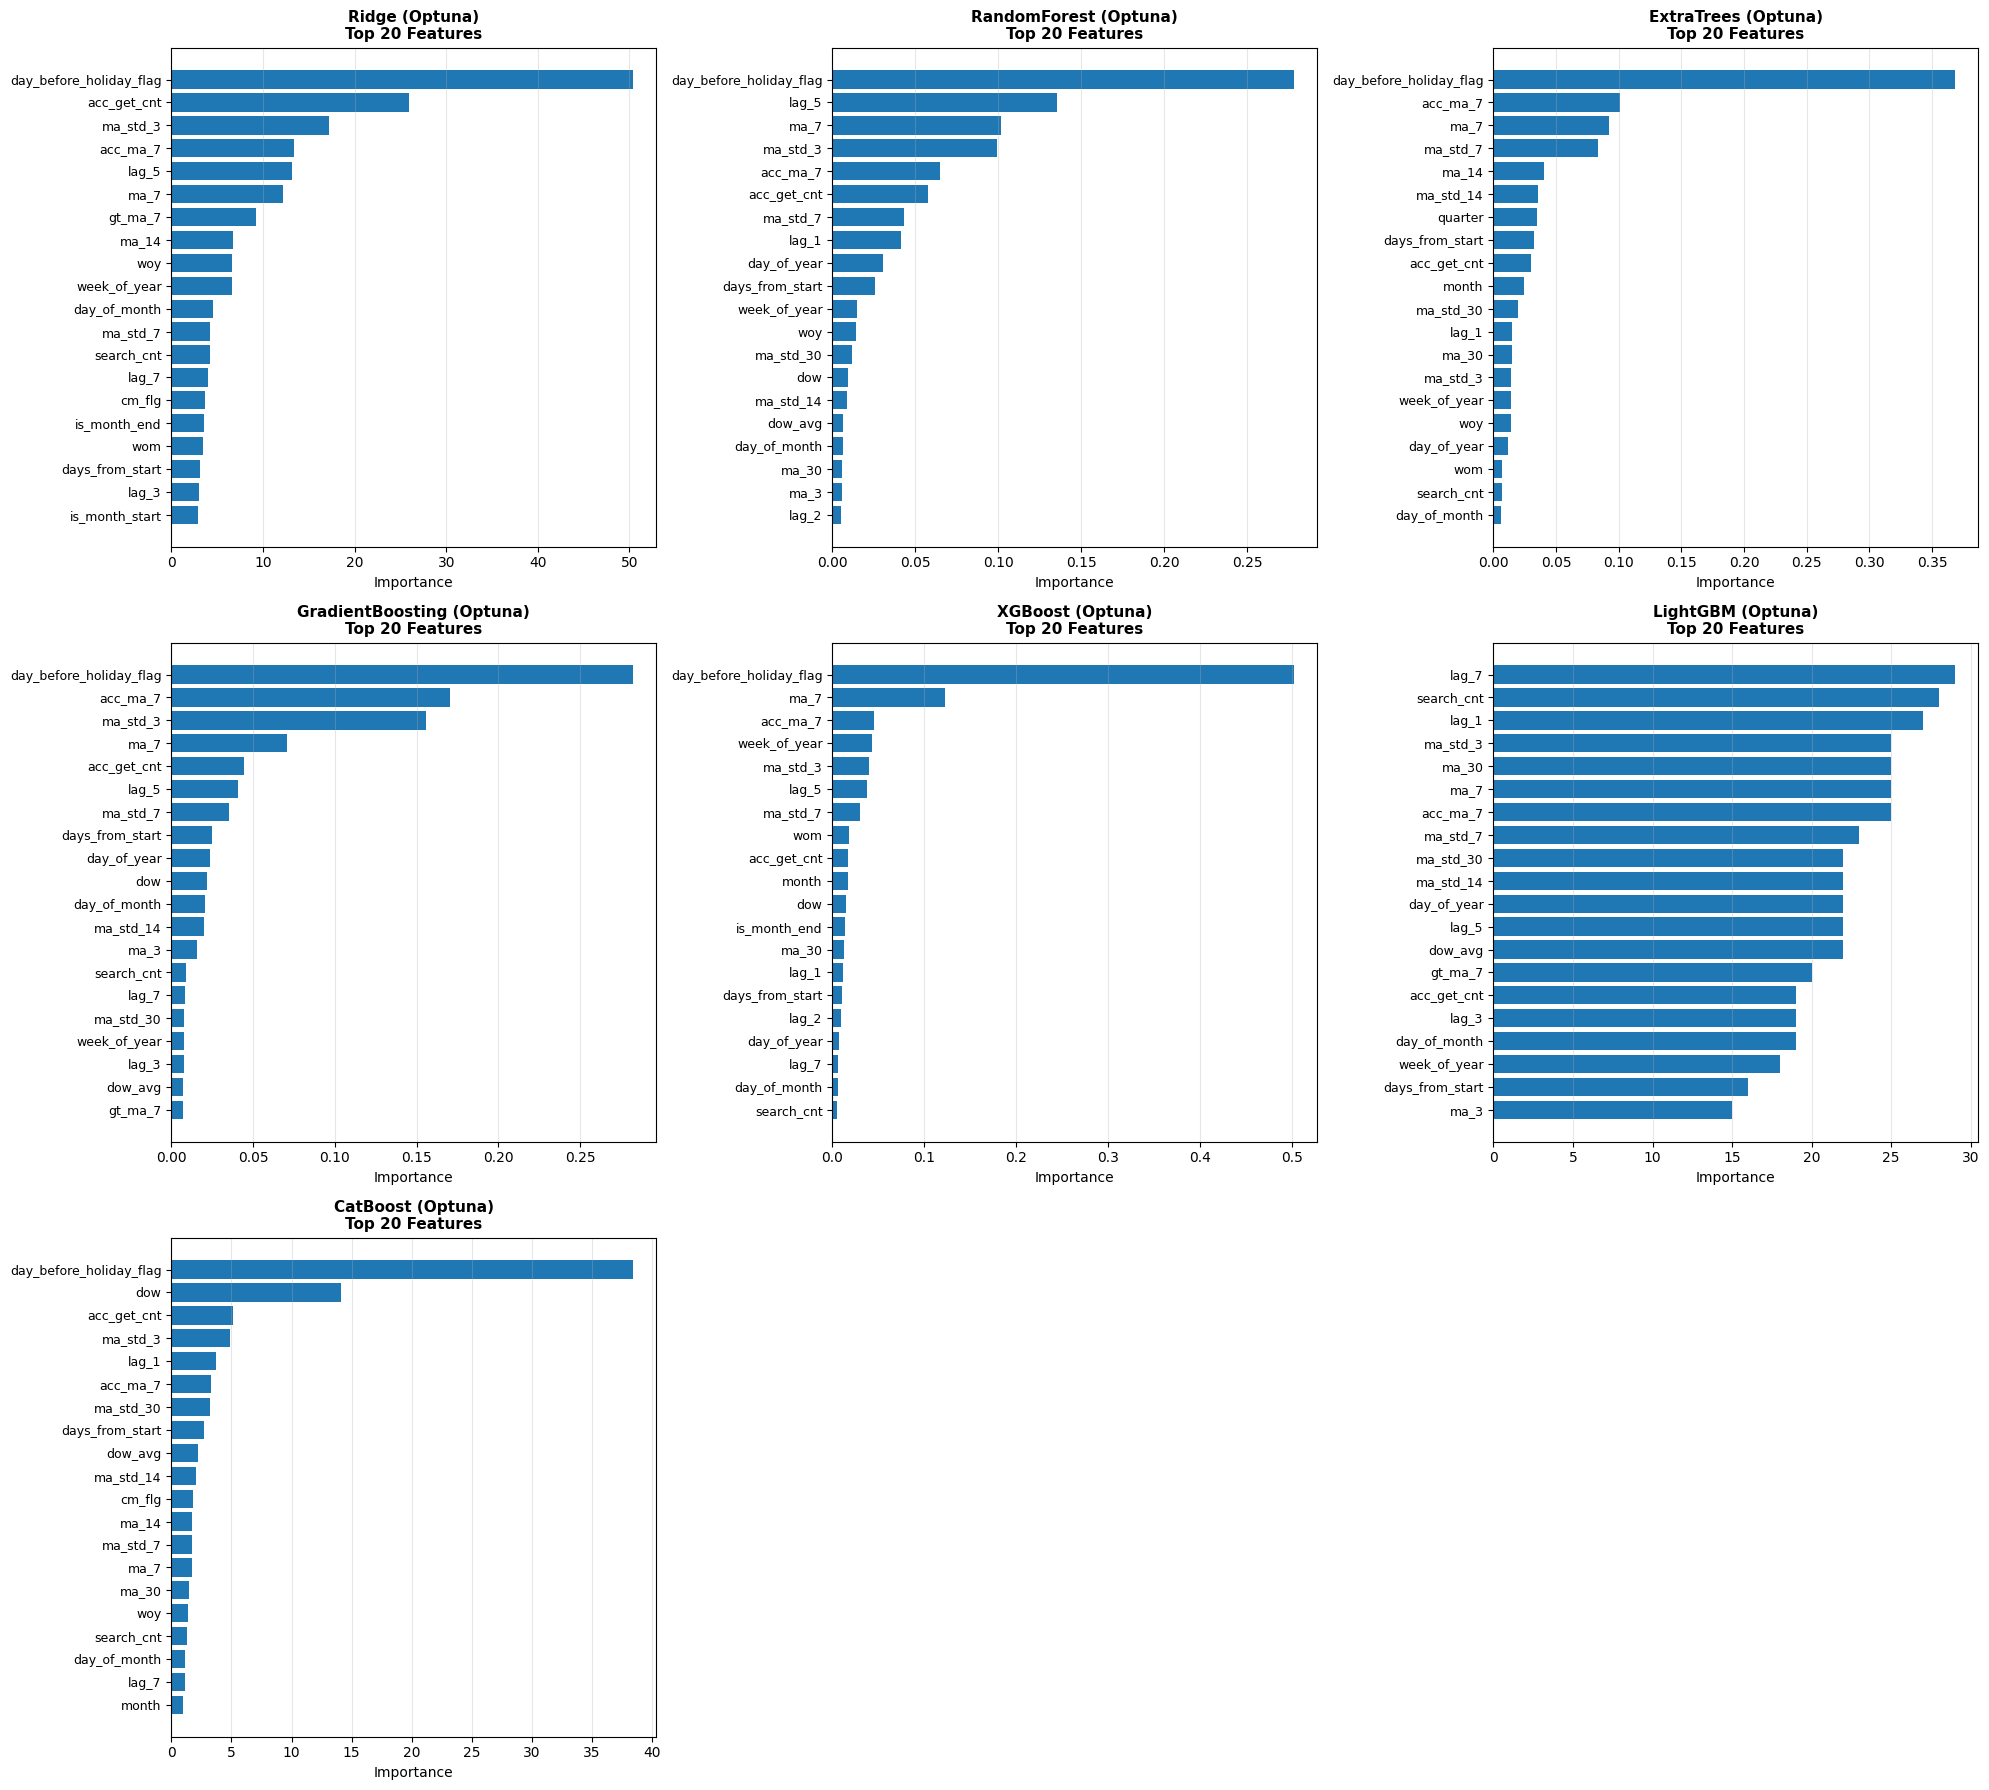


Saved: ../output/exp05/feature_importance_all_models.png


In [29]:
# =========================
# 16) 特徴量重要度の可視化（全モデル）
# =========================
print("\n" + "="*80)
print("Visualizing Feature Importance (All Models)")
print("="*80)

n_models = len(feature_importance_dict)
if n_models == 0:
    print("特徴量重要度を持つモデルがありません")
else:
    # グリッドレイアウトを計算
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
    axes = axes.flatten() if n_models > 1 else [axes]
    
    for idx, (model_name, importances) in enumerate(feature_importance_dict.items()):
        ax = axes[idx]
        
        # Top 20特徴量
        importance_df = pd.DataFrame({
            'feature': feature_cols,
            'importance': importances
        }).sort_values('importance', ascending=False).head(20)
        
        # 横棒グラフ
        importance_df_sorted = importance_df.sort_values('importance')
        ax.barh(range(len(importance_df_sorted)), importance_df_sorted['importance'])
        ax.set_yticks(range(len(importance_df_sorted)))
        ax.set_yticklabels(importance_df_sorted['feature'], fontsize=9)
        ax.set_xlabel('Importance', fontsize=10)
        ax.set_title(f'{model_name}\nTop 20 Features', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')
    
    # 未使用のサブプロットを非表示
    for idx in range(n_models, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/feature_importance_all_models.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nSaved: {output_dir}/feature_importance_all_models.png")


Feature Importance Aggregated Analysis

Saved: ../output/exp05/feature_importance_averaged.csv

Top 20 Features (Averaged across all models):
                feature  avg_importance
day_before_holiday_flag        0.295466
               acc_ma_7        0.074481
                   ma_7        0.072256
               ma_std_3        0.069038
            acc_get_cnt        0.050504
                  lag_5        0.046294
               ma_std_7        0.038810
                    dow        0.031037
                  lag_1        0.024008
        days_from_start        0.023507
           week_of_year        0.021695
              ma_std_14        0.019788
            day_of_year        0.018109
                  ma_14        0.017483
              ma_std_30        0.016977
             search_cnt        0.015740
                  ma_30        0.015317
           day_of_month        0.015202
                  lag_7        0.015171
                gt_ma_7        0.013715


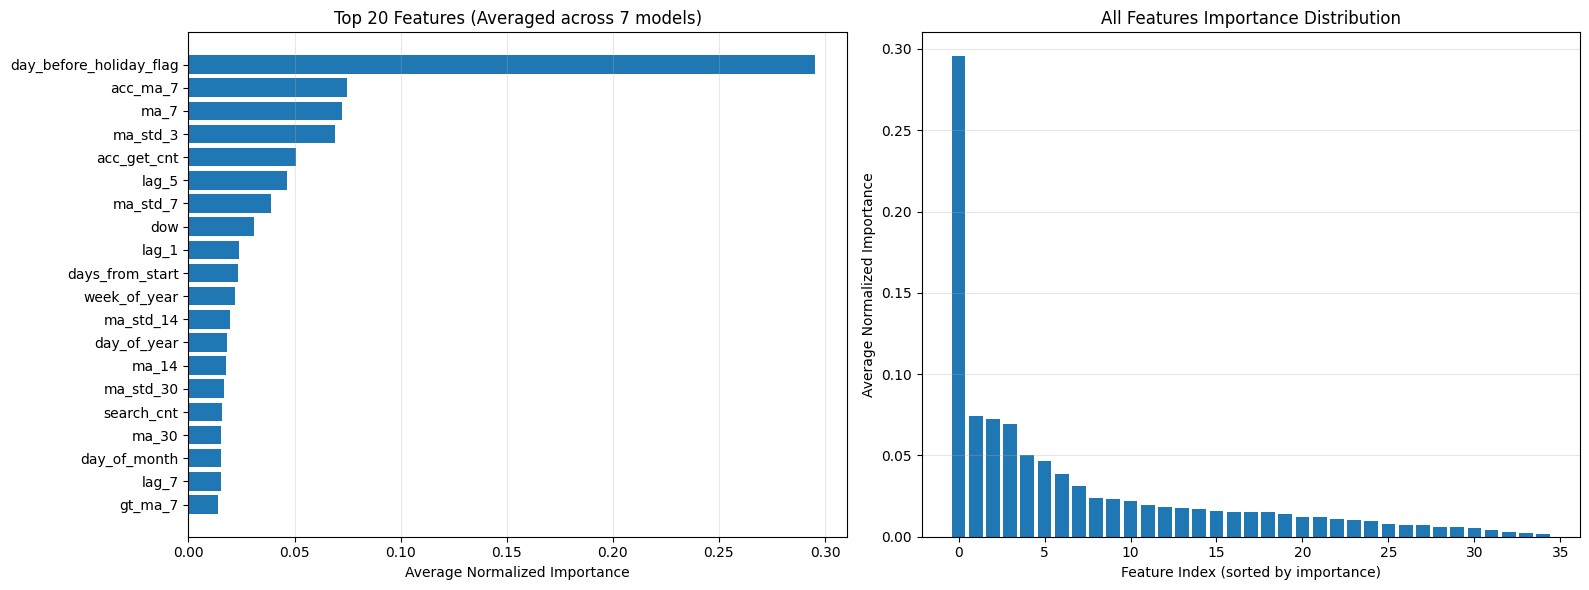


Saved: ../output/exp05/feature_importance_averaged_plot.png


In [30]:
# =========================
# 17) 特徴量重要度の統合分析（全モデル平均）
# =========================
print("\n" + "="*80)
print("Feature Importance Aggregated Analysis")
print("="*80)

if len(feature_importance_dict) > 0:
    # 各モデルの重要度を正規化（0-1スケール）
    normalized_importances = {}
    for model_name, importances in feature_importance_dict.items():
        imp_sum = importances.sum()
        if imp_sum > 0:
            normalized_importances[model_name] = importances / imp_sum
        else:
            normalized_importances[model_name] = importances
    
    # 全モデルの平均重要度を計算
    avg_importance = np.mean(list(normalized_importances.values()), axis=0)
    
    avg_importance_df = pd.DataFrame({
        'feature': feature_cols,
        'avg_importance': avg_importance
    }).sort_values('avg_importance', ascending=False).reset_index(drop=True)
    
    # 保存
    avg_importance_df.to_csv(f"{output_dir}/feature_importance_averaged.csv", index=False)
    print(f"\nSaved: {output_dir}/feature_importance_averaged.csv")
    
    print("\nTop 20 Features (Averaged across all models):")
    print(avg_importance_df.head(20).to_string(index=False))
    
    # 可視化
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 横棒グラフ（Top 20）
    ax = axes[0]
    top20 = avg_importance_df.head(20).sort_values('avg_importance')
    ax.barh(range(len(top20)), top20['avg_importance'])
    ax.set_yticks(range(len(top20)))
    ax.set_yticklabels(top20['feature'])
    ax.set_xlabel('Average Normalized Importance')
    ax.set_title(f'Top 20 Features (Averaged across {len(feature_importance_dict)} models)')
    ax.grid(True, alpha=0.3, axis='x')
    
    # 全特徴量の分布
    ax = axes[1]
    ax.bar(range(len(avg_importance_df)), avg_importance_df['avg_importance'])
    ax.set_xlabel('Feature Index (sorted by importance)')
    ax.set_ylabel('Average Normalized Importance')
    ax.set_title('All Features Importance Distribution')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/feature_importance_averaged_plot.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nSaved: {output_dir}/feature_importance_averaged_plot.png")


Feature Importance by Category

Saved: ../output/exp05/feature_importance_by_category.csv

Category Importance (Average across all models):
Model        Average
Category            
Other       0.295466
Time        0.157044
Moving Std  0.144612
Moving Avg  0.114493
Lag         0.113066
Aggregated  0.103222
External    0.072098


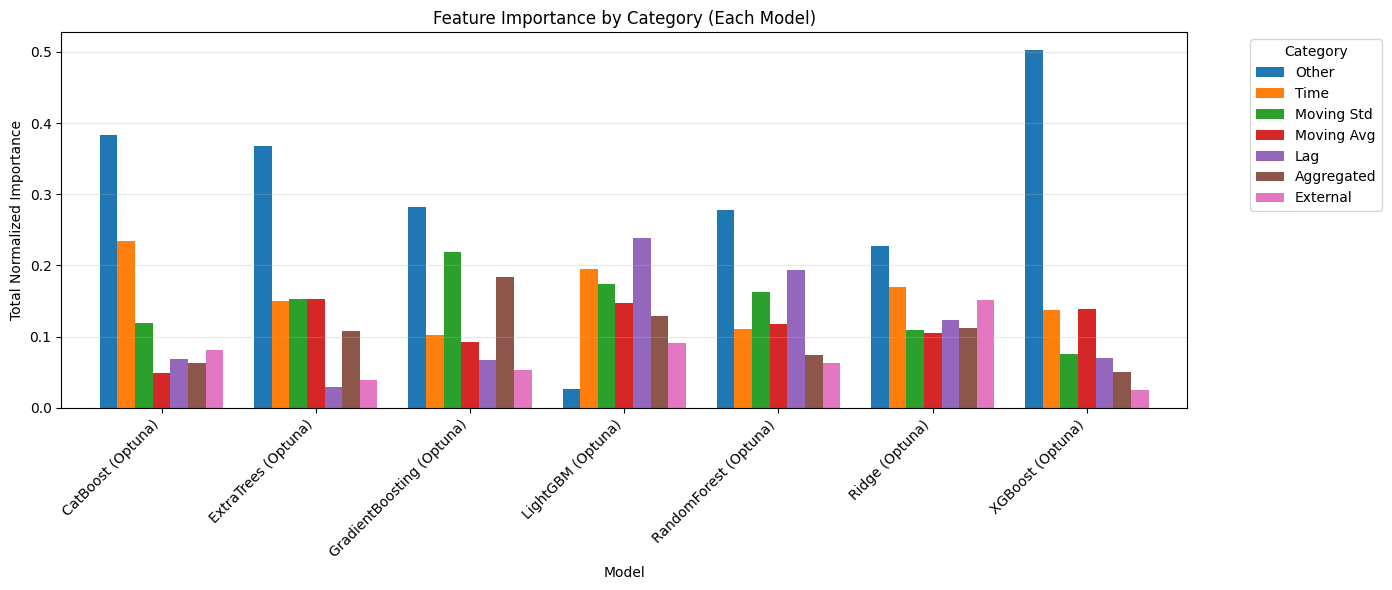

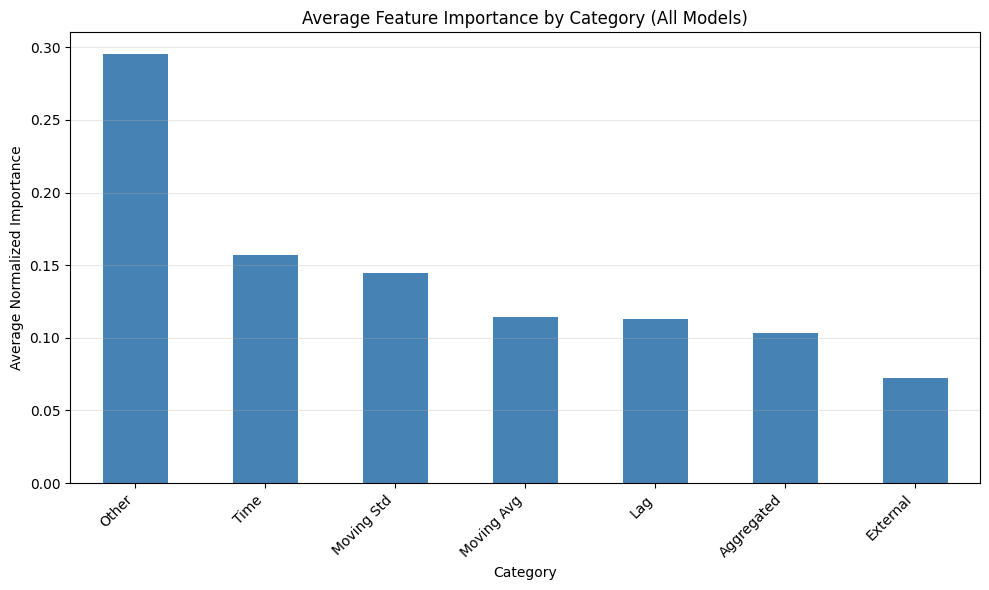


Saved: ../output/exp05/feature_importance_by_category_models.png
Saved: ../output/exp05/feature_importance_by_category_average.png


In [31]:
# =========================
# 18) カテゴリ別の特徴量重要度分析
# =========================
print("\n" + "="*80)
print("Feature Importance by Category")
print("="*80)

if len(feature_importance_dict) > 0:
    # カテゴリ分類
    categories = {
        'Lag': [f'lag_{i}' for i in [1,2,3,5,7,14,30]],
        'Moving Avg': ['ma_3', 'ma_7', 'ma_14', 'ma_30'],
        'Moving Std': ['ma_std_3', 'ma_std_7', 'ma_std_14', 'ma_std_30'],
        'Time': ['dow', 'day_of_month', 'month', 'quarter', 'year', 
                 'days_from_start', 'day_of_year', 'week_of_year',
                 'is_month_start', 'is_month_end', 'woy', 'wom'],
        'External': ['cm_flg', 'acc_get_cnt', 'search_cnt'],
        'Aggregated': ['cm_7d', 'gt_ma_7', 'acc_ma_7', 'dow_avg'],
        'Other': ['day_before_holiday_flag']
    }
    
    # 各モデルのカテゴリ別重要度を計算
    category_results = []
    
    for model_name, importances in normalized_importances.items():
        importance_df = pd.DataFrame({
            'feature': feature_cols,
            'importance': importances
        })
        
        for cat_name, features in categories.items():
            cat_imp = importance_df[importance_df['feature'].isin(features)]['importance'].sum()
            category_results.append({
                'Model': model_name,
                'Category': cat_name,
                'Total_Importance': cat_imp
            })
    
    category_df = pd.DataFrame(category_results)
    
    # ピボットテーブル（モデル×カテゴリ）
    pivot_df = category_df.pivot(index='Category', columns='Model', values='Total_Importance')
    pivot_df['Average'] = pivot_df.mean(axis=1)
    pivot_df = pivot_df.sort_values('Average', ascending=False)
    
    # 保存
    pivot_df.to_csv(f"{output_dir}/feature_importance_by_category.csv")
    print(f"\nSaved: {output_dir}/feature_importance_by_category.csv")
    
    print("\nCategory Importance (Average across all models):")
    print(pivot_df[['Average']].to_string())
    
    # 可視化：カテゴリ別重要度（モデルごと）
    fig, ax = plt.subplots(figsize=(14, 6))
    pivot_df.drop('Average', axis=1).T.plot(kind='bar', ax=ax, width=0.8)
    ax.set_ylabel('Total Normalized Importance')
    ax.set_xlabel('Model')
    ax.set_title('Feature Importance by Category (Each Model)')
    ax.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/feature_importance_by_category_models.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # 可視化：平均カテゴリ重要度
    fig, ax = plt.subplots(figsize=(10, 6))
    pivot_df['Average'].plot(kind='bar', ax=ax, color='steelblue')
    ax.set_ylabel('Average Normalized Importance')
    ax.set_xlabel('Category')
    ax.set_title('Average Feature Importance by Category (All Models)')
    ax.grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/feature_importance_by_category_average.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nSaved: {output_dir}/feature_importance_by_category_models.png")
    print(f"Saved: {output_dir}/feature_importance_by_category_average.png")


土日判定:
  総テストデータ数: 65
  土日数: 0
  平日数: 65

土日の予測値を0に設定しました

調整後の評価指標:
  MAE : 28.270 (調整前: 28.270)
  RMSE: 37.886 (調整前: 37.886)
  R2  : 0.643 (調整前: 0.643)
  WAPE: 28.92% (調整前: 28.92%)

Best Model: HistGradientBoosting (Optuna)


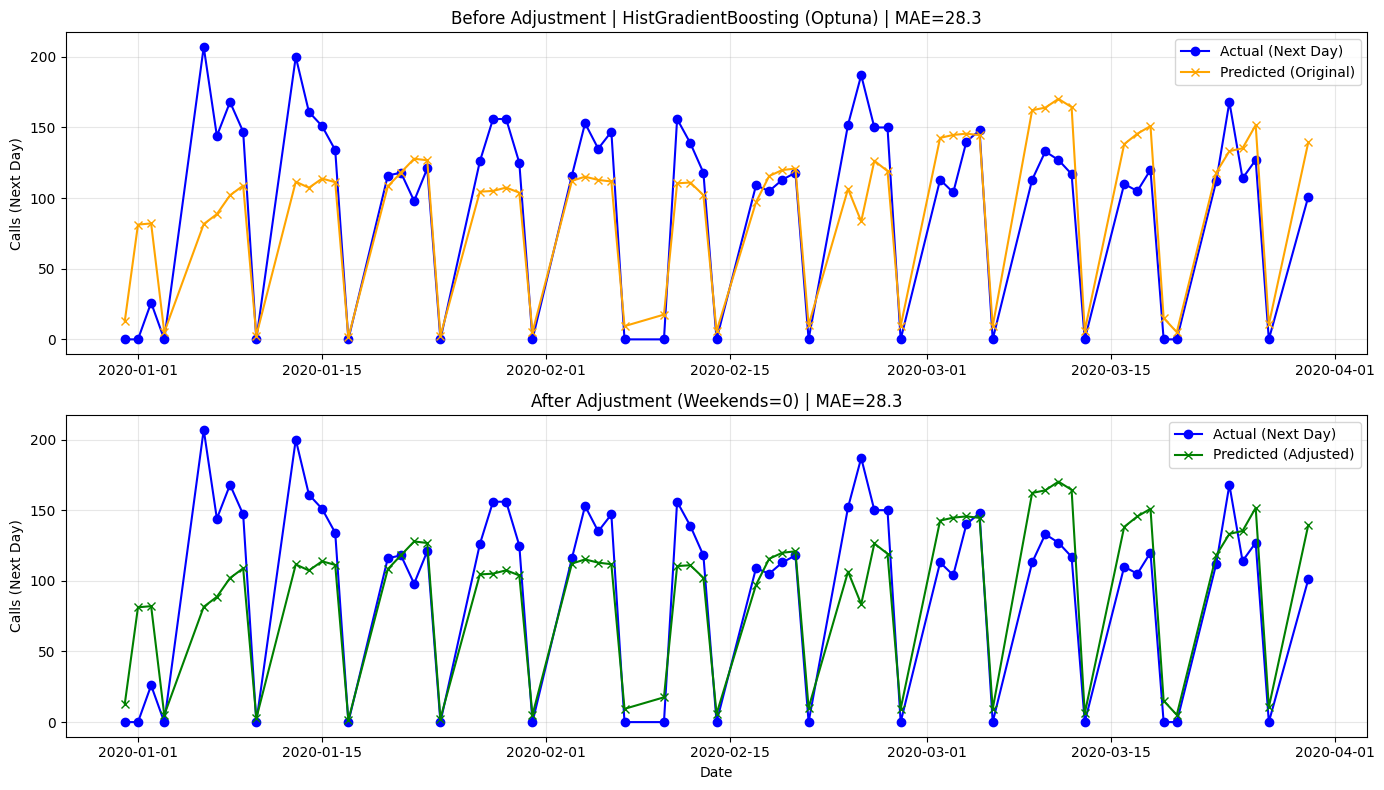

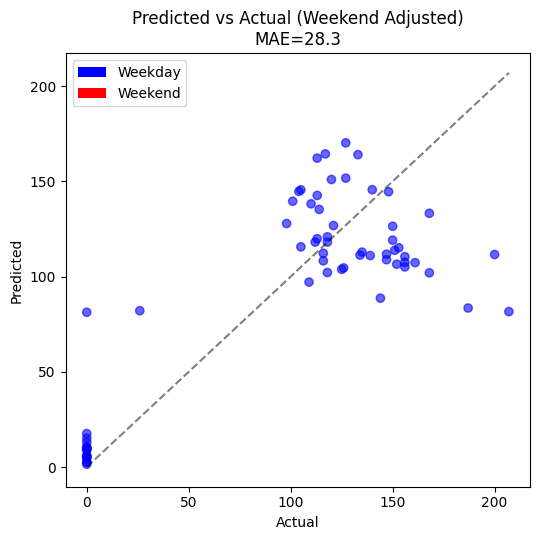


詳細分析:

【土日】 (0日)
  実際の値の合計: 0
  調整前予測の合計: 0
  調整後予測の合計: 0 (全て0)

【平日のみ】 (65日)
  MAE : 28.270
  RMSE: 37.886
  WAPE: 28.92%

Plots saved to ../output/exp05/
exp05 complete (with weekend adjustment)!


In [36]:
# =========================
# 19) Visualization: Prediction vs Actual (土日対応版)
# =========================
import matplotlib.pyplot as plt

# ベストモデルの予測を取得
best_model_name = res_df.iloc[0]['Model']
best_mae = res_df.iloc[0]['MAE']
best_rmse = res_df.iloc[0]['RMSE']
best_r2 = res_df.iloc[0]['R2']

if best_model_name in trained_models:
    model = trained_models[best_model_name]
    
    # XGBoostの場合は型変換済みデータを使用
    if 'XGBoost' in best_model_name:
        best_pred = model.predict(X_test_xgb)
    else:
        best_pred = model.predict(X_test)
else:
    # Baselineの場合
    best_pred = baseline_current_day

# CSV から再読み込み
test_data_for_plot = pd.read_csv("../output/exp05/test_features.csv", parse_dates=["cdr_date"])

# =========================
# 🚨 土日の予測値を0に設定
# =========================
# カレンダー情報を再度読み込み
calender_for_check = pd.read_csv('../input/calender_data.csv', parse_dates=['cdr_date'])

# テストデータとカレンダーをマージしてdow情報を取得
test_with_calendar = test_data_for_plot.merge(
    calender_for_check[['cdr_date', 'dow']], 
    on='cdr_date', 
    how='left',
    suffixes=('', '_cal')
)

# 予測値をコピー
best_pred_adjusted = best_pred.copy()

# 土日判定：dow が 6(土曜) or 7(日曜)
is_weekend = test_with_calendar['dow_cal'].isin([6, 7])

# 土日の予測値を0に設定
best_pred_adjusted[is_weekend] = 0

print(f"\n土日判定:")
print(f"  総テストデータ数: {len(test_with_calendar)}")
print(f"  土日数: {is_weekend.sum()}")
print(f"  平日数: {(~is_weekend).sum()}")
print(f"\n土日の予測値を0に設定しました")

# 調整後の評価指標を再計算
adjusted_metrics = evaluate(y_test, best_pred_adjusted)
print(f"\n調整後の評価指標:")
print(f"  MAE : {adjusted_metrics['MAE']:.3f} (調整前: {best_mae:.3f})")
print(f"  RMSE: {adjusted_metrics['RMSE']:.3f} (調整前: {best_rmse:.3f})")
print(f"  R2  : {adjusted_metrics['R2']:.3f} (調整前: {best_r2:.3f})")
print(f"  WAPE: {adjusted_metrics['WAPE']:.2f}% (調整前: {res_df.iloc[0]['WAPE']:.2f}%)")

print(f"\nBest Model: {best_model_name}")

# プロット用データフレーム作成
plot_df = pd.DataFrame({
    "date": test_data_for_plot['cdr_date'].values,
    "actual": y_test.values,
    "pred_original": np.asarray(best_pred, dtype=float),
    "pred_adjusted": np.asarray(best_pred_adjusted, dtype=float),
    "is_weekend": is_weekend.values
}).sort_values("date")

# 図1：時系列（調整前後比較）
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# 上段：調整前
ax = axes[0]
ax.plot(plot_df["date"], plot_df["actual"], label="Actual (Next Day)", marker='o', color='blue')
ax.plot(plot_df["date"], plot_df["pred_original"], label="Predicted (Original)", marker='x', color='orange')
# 土日をハイライト
weekend_dates = plot_df[plot_df["is_weekend"]]["date"]
for wd in weekend_dates:
    ax.axvline(x=wd, color='lightblue', alpha=0.3, linestyle='--', linewidth=1)
ax.set_title(f"Before Adjustment | {best_model_name} | MAE={best_mae:.1f}")
ax.set_ylabel("Calls (Next Day)")
ax.legend()
ax.grid(True, alpha=0.3)

# 下段：調整後
ax = axes[1]
ax.plot(plot_df["date"], plot_df["actual"], label="Actual (Next Day)", marker='o', color='blue')
ax.plot(plot_df["date"], plot_df["pred_adjusted"], label="Predicted (Adjusted)", marker='x', color='green')
# 土日をハイライト
for wd in weekend_dates:
    ax.axvline(x=wd, color='lightblue', alpha=0.3, linestyle='--', linewidth=1, label='Weekend' if wd == weekend_dates.iloc[0] else '')
ax.set_title(f"After Adjustment (Weekends=0) | MAE={adjusted_metrics['MAE']:.1f}")
ax.set_xlabel("Date")
ax.set_ylabel("Calls (Next Day)")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{output_dir}/prediction_timeseries_weekend_adjusted.png", dpi=150)
plt.show()

# 図2：散布図（調整後のみ）
plt.figure(figsize=(5.5, 5.5))
colors = ['red' if w else 'blue' for w in plot_df["is_weekend"]]
plt.scatter(plot_df["actual"], plot_df["pred_adjusted"], alpha=0.6, c=colors)
mn = min(plot_df["actual"].min(), plot_df["pred_adjusted"].min())
mx = max(plot_df["actual"].max(), plot_df["pred_adjusted"].max())
plt.plot([mn, mx], [mn, mx], 'k--', alpha=0.5)
# カスタム凡例
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', label='Weekday'),
                   Patch(facecolor='red', label='Weekend')]
plt.legend(handles=legend_elements)
plt.title(f"Predicted vs Actual (Weekend Adjusted)\nMAE={adjusted_metrics['MAE']:.1f}")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.savefig(f"{output_dir}/prediction_scatter_weekend_adjusted.png", dpi=150)
plt.show()

# 土日のみのエラー分析
weekend_df = plot_df[plot_df["is_weekend"]]
weekday_df = plot_df[~plot_df["is_weekend"]]

print(f"\n詳細分析:")
print(f"\n【土日】 ({len(weekend_df)}日)")
print(f"  実際の値の合計: {weekend_df['actual'].sum():.0f}")
print(f"  調整前予測の合計: {weekend_df['pred_original'].sum():.0f}")
print(f"  調整後予測の合計: {weekend_df['pred_adjusted'].sum():.0f} (全て0)")

if len(weekday_df) > 0:
    weekday_metrics = evaluate(weekday_df['actual'].values, weekday_df['pred_adjusted'].values)
    print(f"\n【平日のみ】 ({len(weekday_df)}日)")
    print(f"  MAE : {weekday_metrics['MAE']:.3f}")
    print(f"  RMSE: {weekday_metrics['RMSE']:.3f}")
    print(f"  WAPE: {weekday_metrics['WAPE']:.2f}%")

print(f"\nPlots saved to {output_dir}/")
print("="*80)
print("exp05 complete (with weekend adjustment)!")
print("="*80)

SHAP Analysis for All Models

XGBoost SHAP Analysis


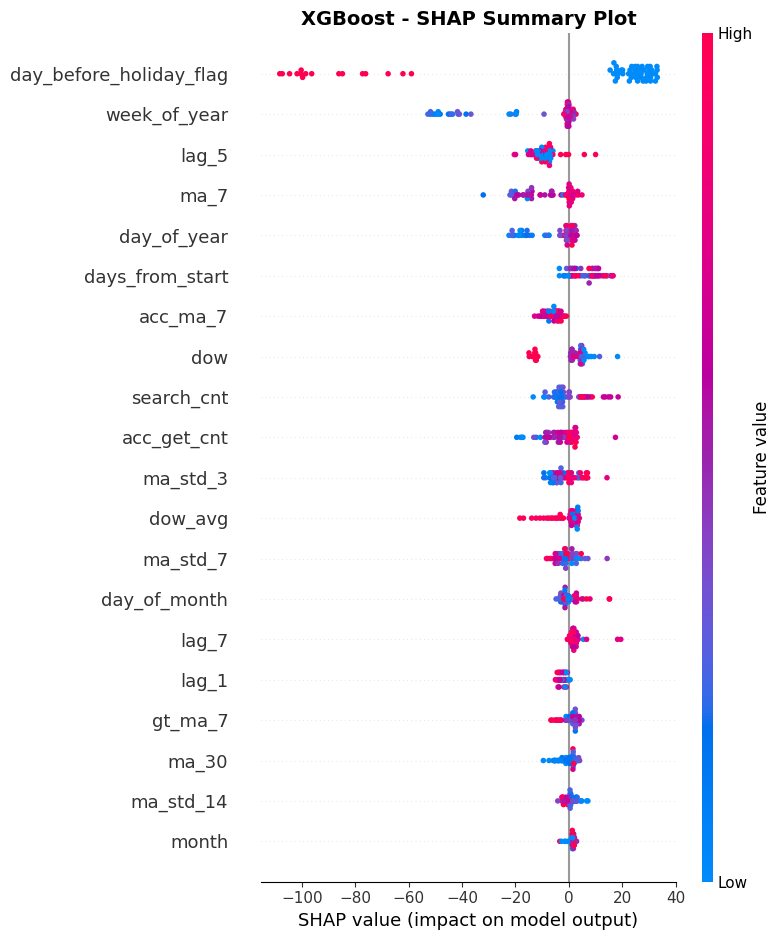

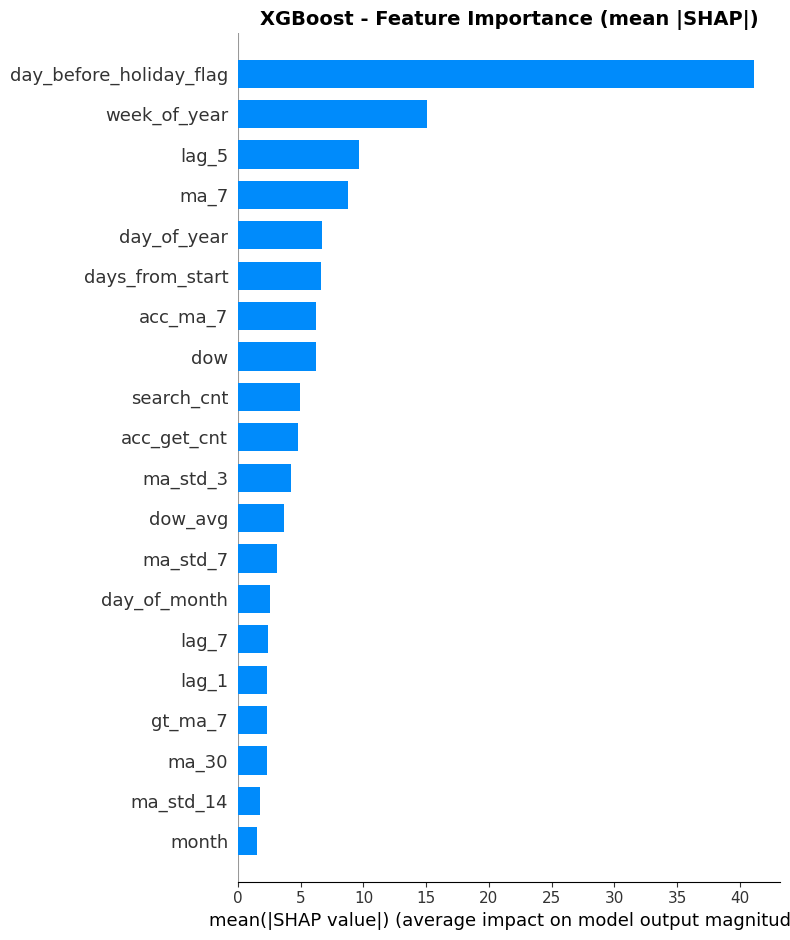


LightGBM SHAP Analysis


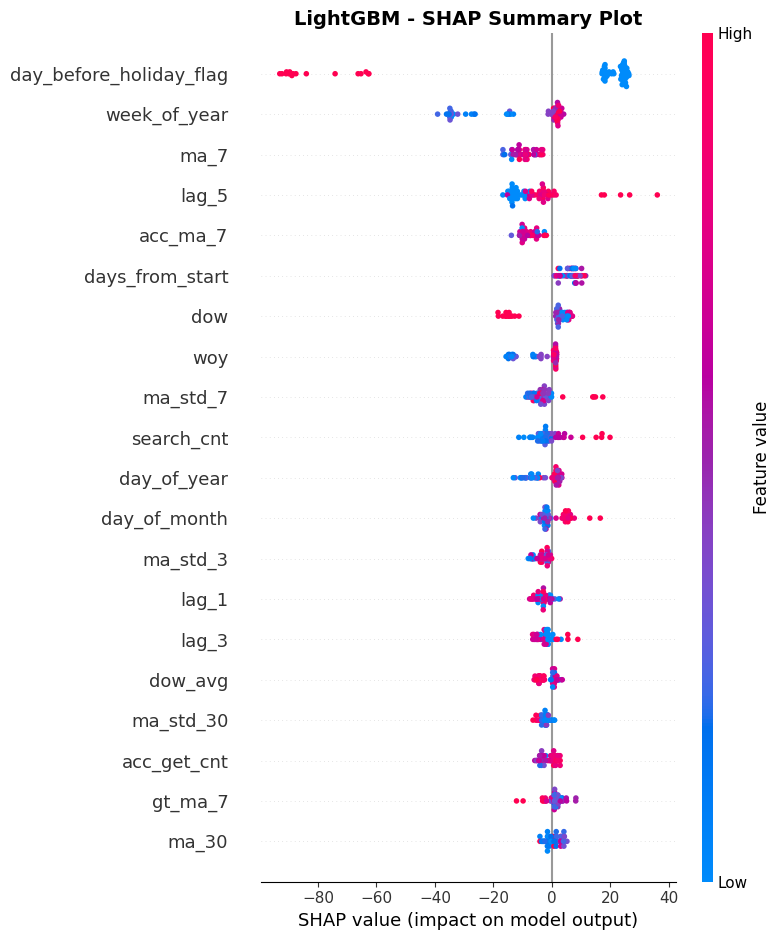

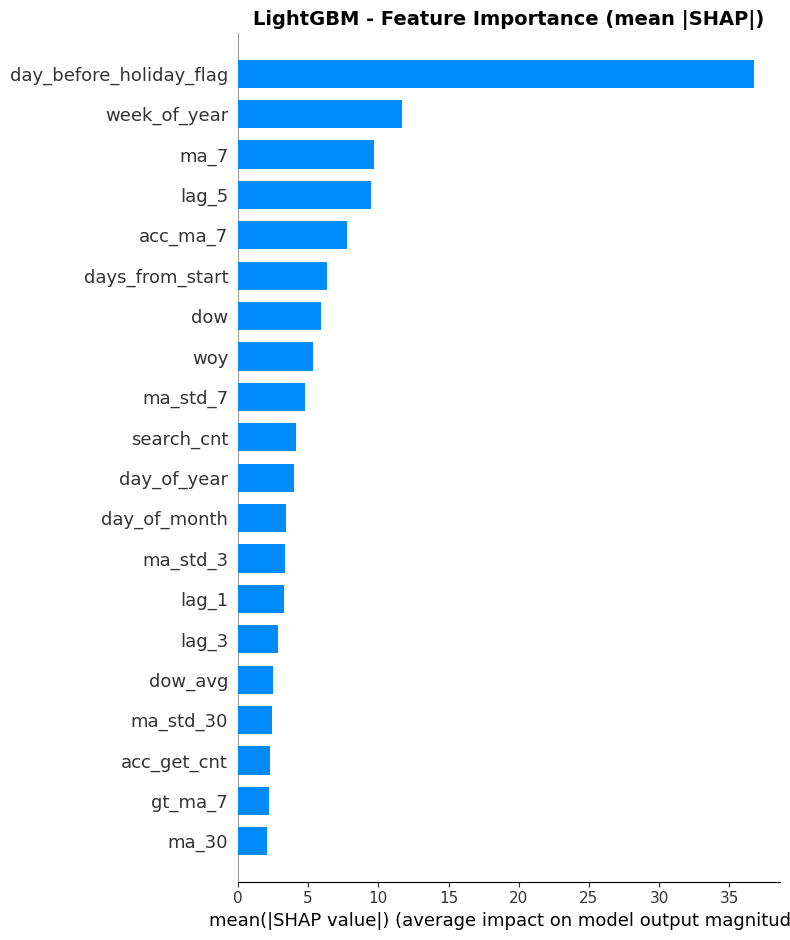


CatBoost SHAP Analysis


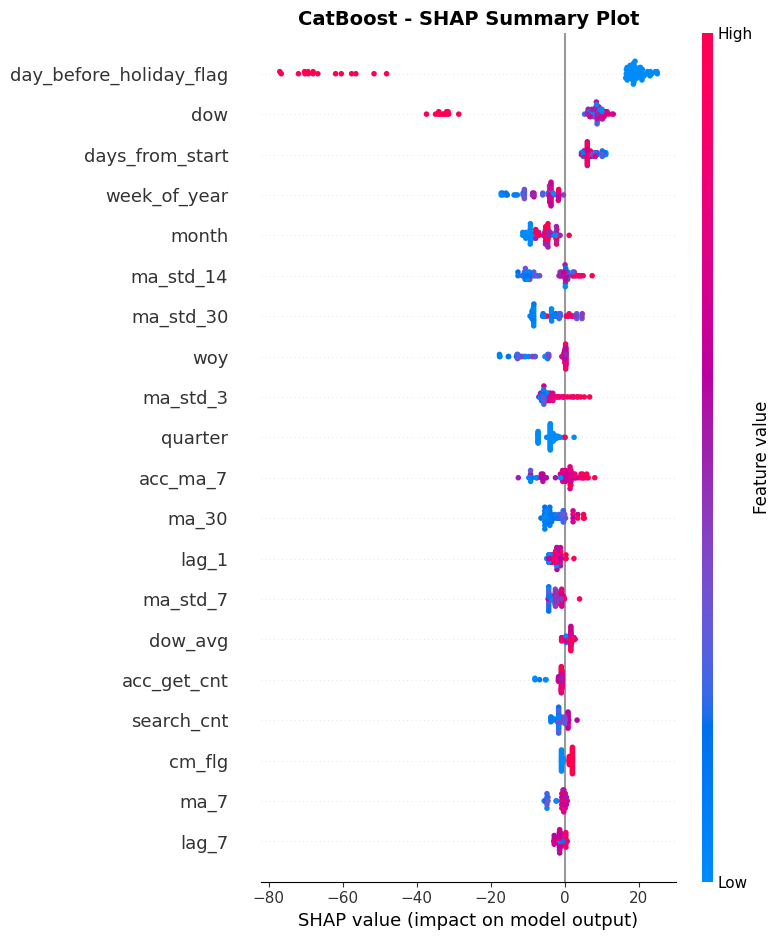

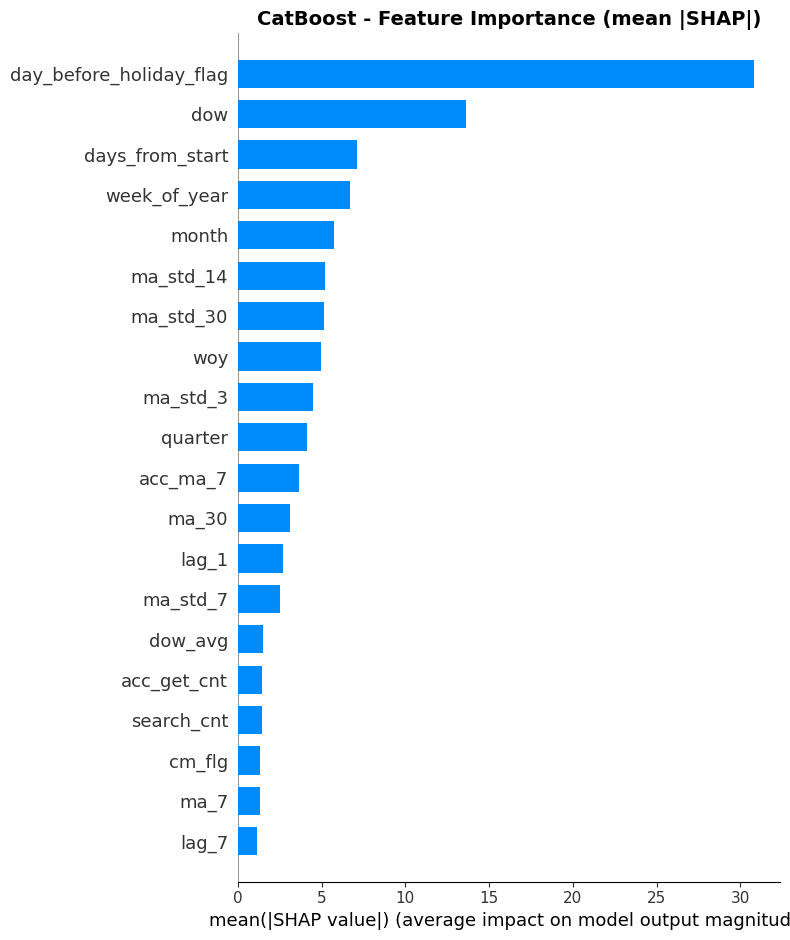


RandomForest SHAP Analysis


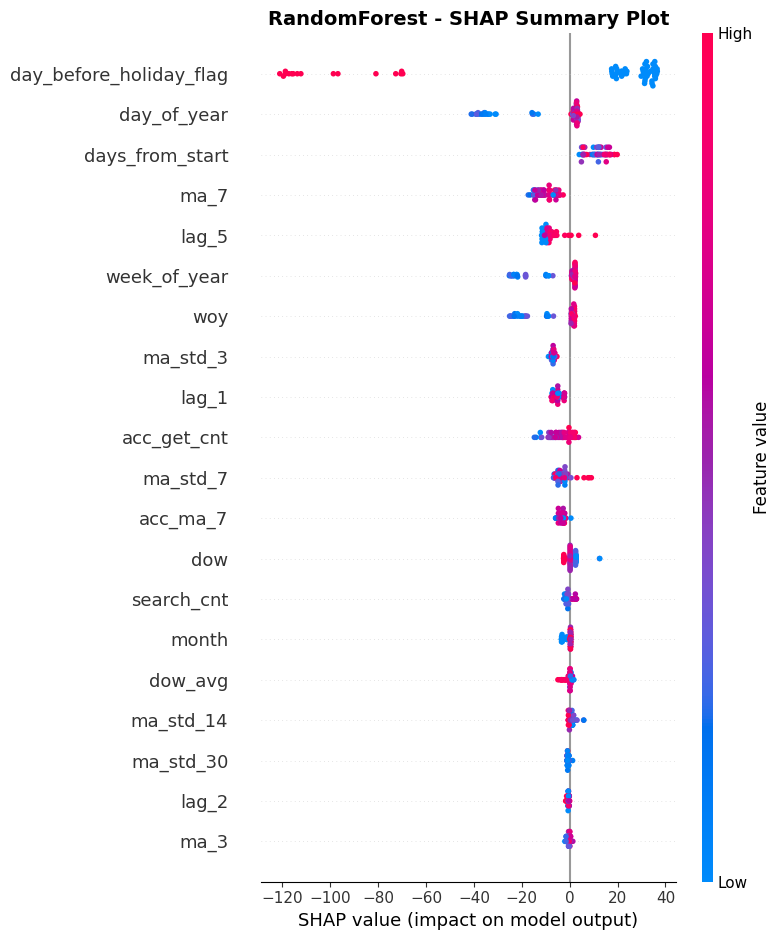

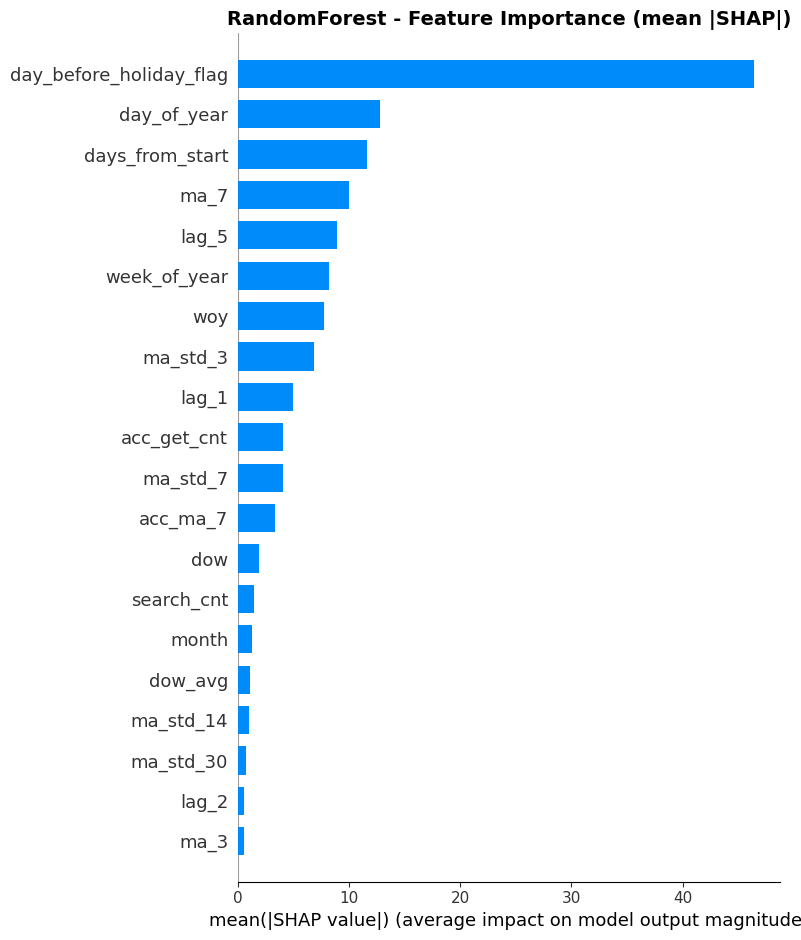


ExtraTrees SHAP Analysis


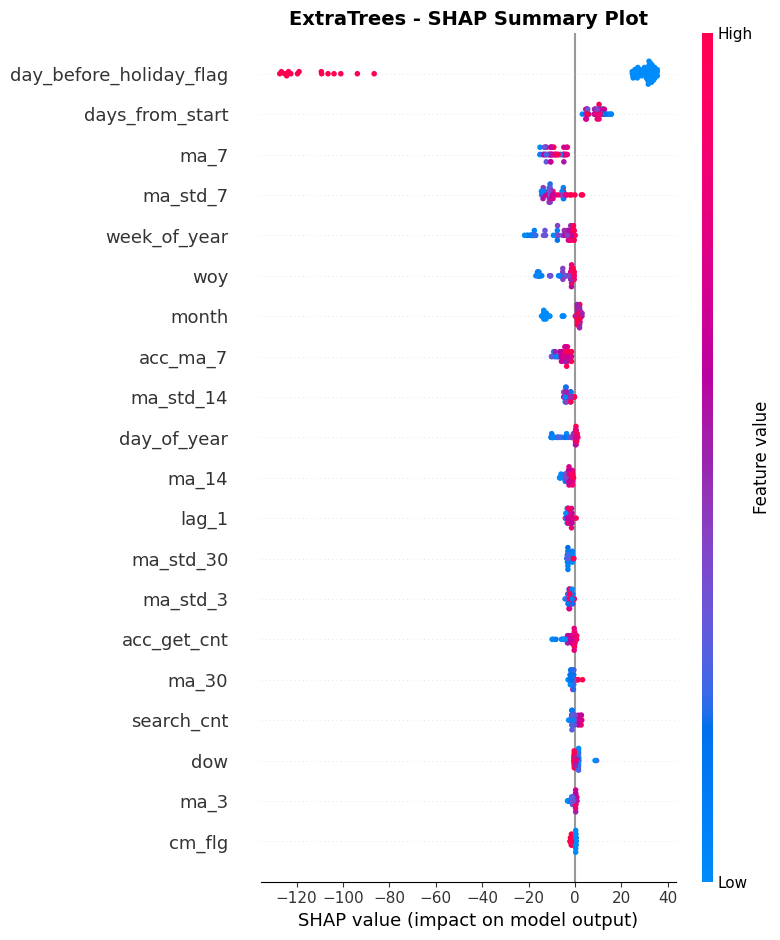

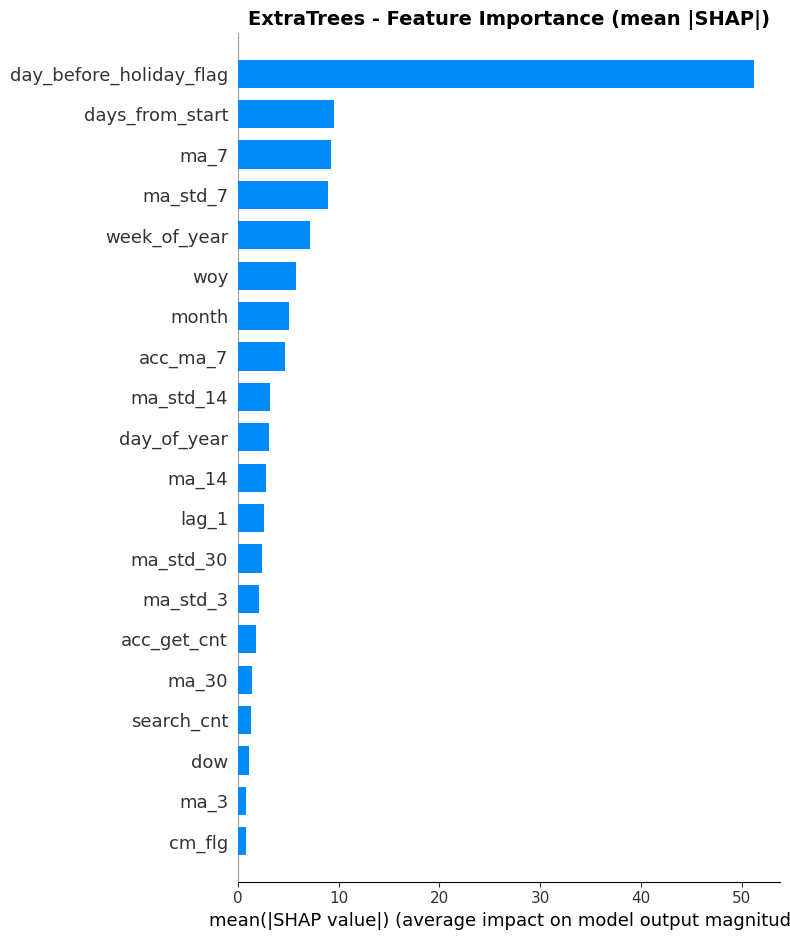


GradientBoosting SHAP Analysis


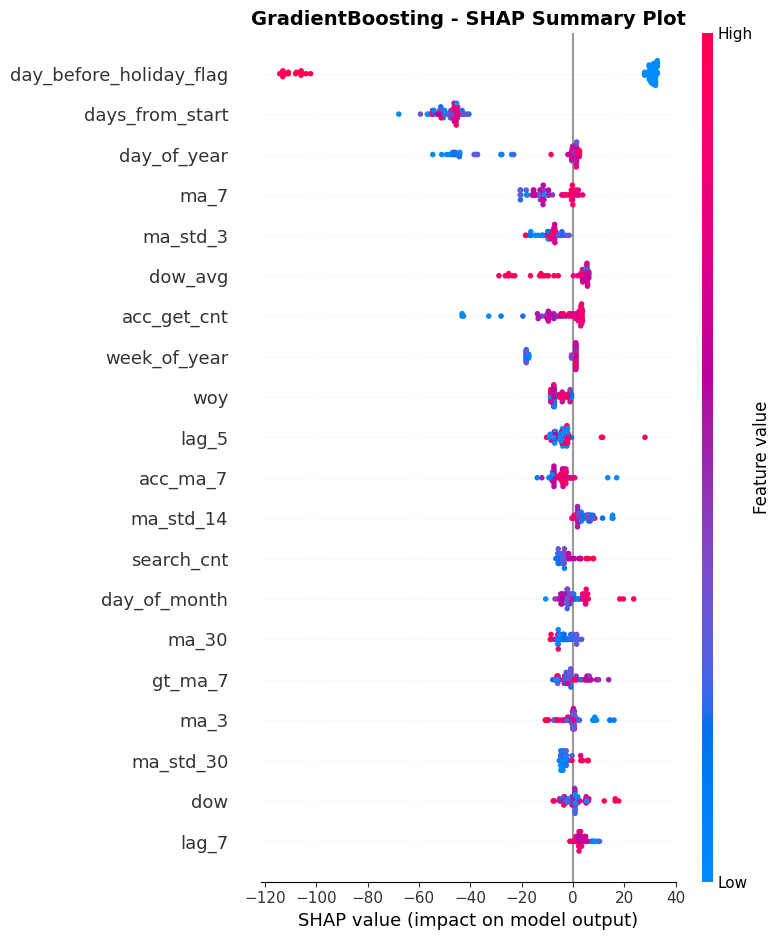

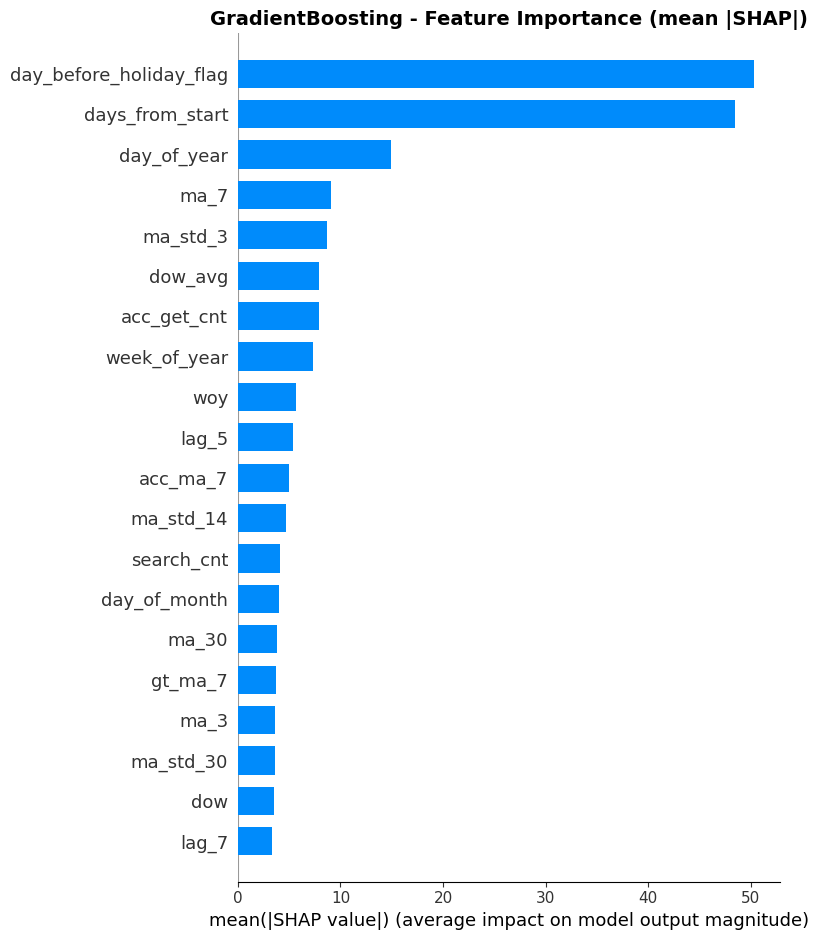


HistGradientBoosting SHAP Analysis


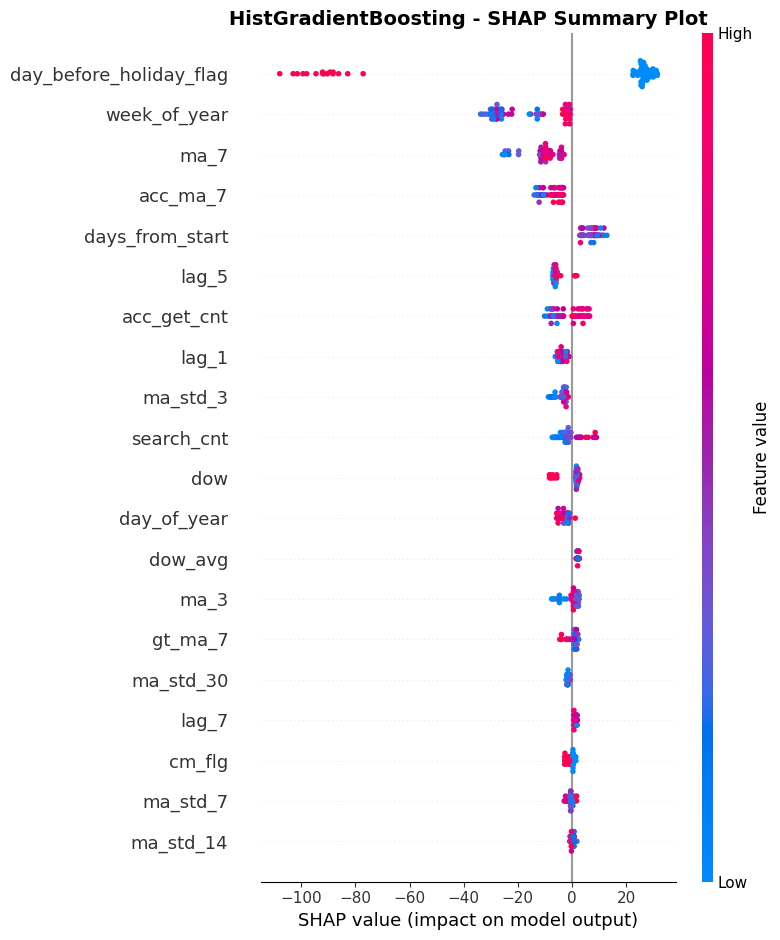

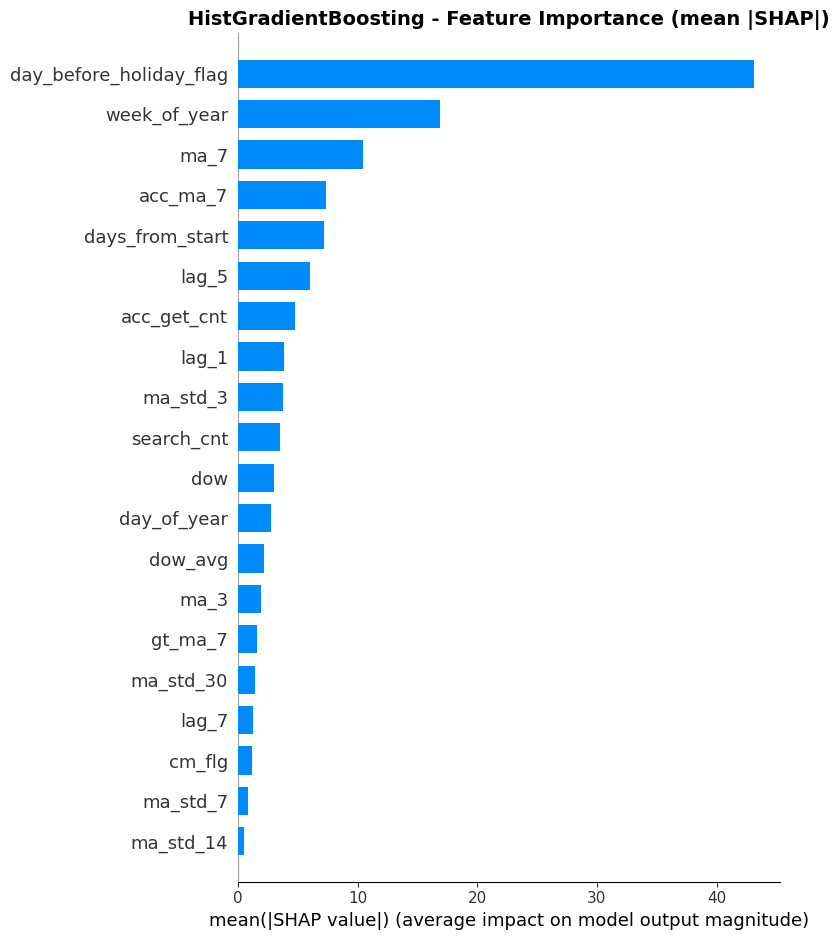


Ridge SHAP Analysis (KernelExplainer - slow)


AttributeError: property 'feature_names_in_' of 'Pipeline' object has no setter

In [38]:
# ==================================================================================
# SHAP値による特徴量重要度分析（全モデル対応）
# ==================================================================================
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# まずSHAPをインストール（必要な場合）
# !pip install shap

print("=" * 80)
print("SHAP Analysis for All Models")
print("=" * 80)

# 説明用のサンプルデータ（テストデータ全体だと時間がかかるので100サンプルに制限）
X_explain = X_test.iloc[:100].copy()

# 各モデルのSHAP値を計算・可視化
shap_results = {}

# ヘルパー関数：モデルがPipelineかどうかを判定
def get_model(model_obj):
    """Pipelineの場合はmodelステップを取得、そうでなければそのまま返す"""
    if hasattr(model_obj, 'named_steps'):
        return model_obj.named_steps['model']
    else:
        return model_obj

# ==================================================================================
# 1. Tree-based models (XGBoost, LightGBM, CatBoost, RandomForest, ExtraTrees)
# ==================================================================================

# XGBoost
if 'XGBoost (Optuna)' in trained_models:
    print("\n" + "=" * 80)
    print("XGBoost SHAP Analysis")
    print("=" * 80)
    
    model_obj = trained_models['XGBoost (Optuna)']
    xgb_model = get_model(model_obj)
    
    # Tree Explainerを使用
    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(X_explain)
    
    shap_results['XGBoost'] = {
        'explainer': explainer,
        'shap_values': shap_values,
        'base_value': explainer.expected_value
    }
    
    # Summary Plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_explain, show=False)
    plt.title("XGBoost - SHAP Summary Plot", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/shap_xgboost_summary.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Feature Importance (mean |SHAP|)
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_explain, plot_type="bar", show=False)
    plt.title("XGBoost - Feature Importance (mean |SHAP|)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/shap_xgboost_importance.png', dpi=150, bbox_inches='tight')
    plt.show()

# LightGBM
if 'LightGBM (Optuna)' in trained_models:
    print("\n" + "=" * 80)
    print("LightGBM SHAP Analysis")
    print("=" * 80)
    
    model_obj = trained_models['LightGBM (Optuna)']
    lgb_model = get_model(model_obj)
    
    explainer = shap.TreeExplainer(lgb_model)
    shap_values = explainer.shap_values(X_explain)
    
    shap_results['LightGBM'] = {
        'explainer': explainer,
        'shap_values': shap_values,
        'base_value': explainer.expected_value
    }
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_explain, show=False)
    plt.title("LightGBM - SHAP Summary Plot", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/shap_lightgbm_summary.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_explain, plot_type="bar", show=False)
    plt.title("LightGBM - Feature Importance (mean |SHAP|)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/shap_lightgbm_importance.png', dpi=150, bbox_inches='tight')
    plt.show()

# CatBoost
if 'CatBoost (Optuna)' in trained_models:
    print("\n" + "=" * 80)
    print("CatBoost SHAP Analysis")
    print("=" * 80)
    
    model_obj = trained_models['CatBoost (Optuna)']
    cat_model = get_model(model_obj)
    
    explainer = shap.TreeExplainer(cat_model)
    shap_values = explainer.shap_values(X_explain)
    
    shap_results['CatBoost'] = {
        'explainer': explainer,
        'shap_values': shap_values,
        'base_value': explainer.expected_value
    }
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_explain, show=False)
    plt.title("CatBoost - SHAP Summary Plot", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/shap_catboost_summary.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_explain, plot_type="bar", show=False)
    plt.title("CatBoost - Feature Importance (mean |SHAP|)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/shap_catboost_importance.png', dpi=150, bbox_inches='tight')
    plt.show()

# RandomForest
if 'RandomForest (Optuna)' in trained_models:
    print("\n" + "=" * 80)
    print("RandomForest SHAP Analysis")
    print("=" * 80)
    
    model_obj = trained_models['RandomForest (Optuna)']
    rf_model = get_model(model_obj)
    
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_explain)
    
    shap_results['RandomForest'] = {
        'explainer': explainer,
        'shap_values': shap_values,
        'base_value': explainer.expected_value
    }
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_explain, show=False)
    plt.title("RandomForest - SHAP Summary Plot", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/shap_randomforest_summary.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_explain, plot_type="bar", show=False)
    plt.title("RandomForest - Feature Importance (mean |SHAP|)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/shap_randomforest_importance.png', dpi=150, bbox_inches='tight')
    plt.show()

# ExtraTrees
if 'ExtraTrees (Optuna)' in trained_models:
    print("\n" + "=" * 80)
    print("ExtraTrees SHAP Analysis")
    print("=" * 80)
    
    model_obj = trained_models['ExtraTrees (Optuna)']
    et_model = get_model(model_obj)
    
    explainer = shap.TreeExplainer(et_model)
    shap_values = explainer.shap_values(X_explain)
    
    shap_results['ExtraTrees'] = {
        'explainer': explainer,
        'shap_values': shap_values,
        'base_value': explainer.expected_value
    }
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_explain, show=False)
    plt.title("ExtraTrees - SHAP Summary Plot", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/shap_extratrees_summary.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_explain, plot_type="bar", show=False)
    plt.title("ExtraTrees - Feature Importance (mean |SHAP|)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/shap_extratrees_importance.png', dpi=150, bbox_inches='tight')
    plt.show()

# GradientBoosting
if 'GradientBoosting (Optuna)' in trained_models:
    print("\n" + "=" * 80)
    print("GradientBoosting SHAP Analysis")
    print("=" * 80)
    
    model_obj = trained_models['GradientBoosting (Optuna)']
    gb_model = get_model(model_obj)
    
    explainer = shap.TreeExplainer(gb_model)
    shap_values = explainer.shap_values(X_explain)
    
    shap_results['GradientBoosting'] = {
        'explainer': explainer,
        'shap_values': shap_values,
        'base_value': explainer.expected_value
    }
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_explain, show=False)
    plt.title("GradientBoosting - SHAP Summary Plot", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/shap_gradientboosting_summary.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_explain, plot_type="bar", show=False)
    plt.title("GradientBoosting - Feature Importance (mean |SHAP|)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/shap_gradientboosting_importance.png', dpi=150, bbox_inches='tight')
    plt.show()

# HistGradientBoosting
if 'HistGradientBoosting (Optuna)' in trained_models:
    print("\n" + "=" * 80)
    print("HistGradientBoosting SHAP Analysis")
    print("=" * 80)
    
    model_obj = trained_models['HistGradientBoosting (Optuna)']
    hgb_model = get_model(model_obj)
    
    explainer = shap.TreeExplainer(hgb_model)
    shap_values = explainer.shap_values(X_explain)
    
    shap_results['HistGradientBoosting'] = {
        'explainer': explainer,
        'shap_values': shap_values,
        'base_value': explainer.expected_value
    }
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_explain, show=False)
    plt.title("HistGradientBoosting - SHAP Summary Plot", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/shap_histgradientboosting_summary.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_explain, plot_type="bar", show=False)
    plt.title("HistGradientBoosting - Feature Importance (mean |SHAP|)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/shap_histgradientboosting_importance.png', dpi=150, bbox_inches='tight')
    plt.show()

# ==================================================================================
# 2. Linear model (Ridge) - KernelExplainerを使用
# ==================================================================================

if 'Ridge (Optuna)' in trained_models:
    print("\n" + "=" * 80)
    print("Ridge SHAP Analysis (KernelExplainer - slow)")
    print("=" * 80)
    
    model_obj = trained_models['Ridge (Optuna)']
    
    # 背景データ（訓練データから100サンプルランダム抽出）
    X_background = shap.sample(X_train, 100)
    
    # predict関数を取得
    if hasattr(model_obj, 'predict'):
        predict_fn = model_obj.predict
    else:
        predict_fn = lambda x: model_obj.predict(x)
    
    # KernelExplainer（遅いので小サンプルで実行）
    explainer = shap.KernelExplainer(predict_fn, X_background)
    shap_values = explainer.shap_values(X_explain.iloc[:50])  # 50サンプルに制限
    
    shap_results['Ridge'] = {
        'explainer': explainer,
        'shap_values': shap_values,
        'base_value': explainer.expected_value
    }
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_explain.iloc[:50], show=False)
    plt.title("Ridge - SHAP Summary Plot (50 samples)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/shap_ridge_summary.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_explain.iloc[:50], plot_type="bar", show=False)
    plt.title("Ridge - Feature Importance (mean |SHAP|)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/shap_ridge_importance.png', dpi=150, bbox_inches='tight')
    plt.show()

# ==================================================================================
# 3. 個別予測の説明（Waterfall Plot）
# ==================================================================================

print("\n" + "=" * 80)
print("Individual Prediction Explanation (Waterfall Plot)")
print("=" * 80)

# ベストモデルで個別予測を説明
if 'CatBoost' in shap_results:
    model_name = 'CatBoost'
    shap_vals = shap_results['CatBoost']['shap_values']
    base_val = shap_results['CatBoost']['base_value']
    
    # 最初の3サンプルについてWaterfall Plot
    for i in range(min(3, len(X_explain))):
        plt.figure(figsize=(10, 6))
        shap.plots._waterfall.waterfall_legacy(
            base_val, 
            shap_vals[i], 
            feature_names=X_explain.columns.tolist(),
            max_display=15,
            show=False
        )
        plt.title(f"{model_name} - Sample {i+1} Prediction Explanation", fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'{output_dir}/shap_{model_name.lower()}_waterfall_sample{i+1}.png', dpi=150, bbox_inches='tight')
        plt.show()

# ==================================================================================
# 4. Dependence Plot（特定特徴量の効果）
# ==================================================================================

print("\n" + "=" * 80)
print("Dependence Plots - Top Features")
print("=" * 80)

# CatBoostで上位5特徴量のDependence Plot
if 'CatBoost' in shap_results:
    shap_vals = shap_results['CatBoost']['shap_values']
    
    # 平均|SHAP|で上位5特徴量を取得
    mean_abs_shap = np.abs(shap_vals).mean(axis=0)
    top_features_idx = np.argsort(mean_abs_shap)[-5:][::-1]
    top_features = X_explain.columns[top_features_idx]
    
    print(f"\nTop 5 features by mean |SHAP|:")
    for i, feat in enumerate(top_features, 1):
        print(f"  {i}. {feat}")
    
    # Dependence Plotを作成
    for feat in top_features:
        plt.figure(figsize=(10, 6))
        shap.dependence_plot(
            feat, 
            shap_vals, 
            X_explain, 
            show=False
        )
        plt.title(f"CatBoost - Dependence Plot: {feat}", fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'{output_dir}/shap_catboost_dependence_{feat}.png', dpi=150, bbox_inches='tight')
        plt.show()

print("\n" + "=" * 80)
print("SHAP Analysis Complete!")
print("=" * 80)
print(f"All plots saved to: {output_dir}/")

# =========================
# 19) Visualization: Prediction vs Actual
# =========================
import matplotlib.pyplot as plt

# ベストモデルの予測を取得
best_model_name = res_df.iloc[0]['Model']
best_mae = res_df.iloc[0]['MAE']
best_rmse = res_df.iloc[0]['RMSE']
best_r2 = res_df.iloc[0]['R2']

if best_model_name in trained_models:
    model = trained_models[best_model_name]
    
    # XGBoostの場合は型変換済みデータを使用
    if 'XGBoost' in best_model_name:
        best_pred = model.predict(X_test_xgb)
    else:
        best_pred = model.predict(X_test)
else:
    # Baselineの場合
    best_pred = baseline_current_day

print(f"\nBest Model: {best_model_name}")
print(f"Test MAE : {best_mae:.3f}")
print(f"Test RMSE: {best_rmse:.3f}")
print(f"Test R2  : {best_r2:.3f}")

# CSV から再読み込み
test_data_for_plot = pd.read_csv("../output/exp05/test_features.csv", parse_dates=["cdr_date"])
plot_df = pd.DataFrame({
    "date": test_data_for_plot['cdr_date'].values,
    "actual": y_test.values,
    "pred": np.asarray(best_pred, dtype=float)
}).sort_values("date")

# 図1：時系列
plt.figure(figsize=(12, 4))
plt.plot(plot_df["date"], plot_df["actual"], label="Actual (Next Day)", marker='o')
plt.plot(plot_df["date"], plot_df["pred"], label="Predicted", marker='x')
plt.title(f"exp05: Next-Day Prediction (Optuna) | {best_model_name} | MAE={best_mae:.1f}, RMSE={best_rmse:.1f}, R2={best_r2:.2f}")
plt.xlabel("Date")
plt.ylabel("Calls (Next Day)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{output_dir}/prediction_timeseries.png", dpi=150)
plt.show()

# 図2：散布図
plt.figure(figsize=(5.5, 5.5))
plt.scatter(plot_df["actual"], plot_df["pred"], alpha=0.6)
mn = min(plot_df["actual"].min(), plot_df["pred"].min())
mx = max(plot_df["actual"].max(), plot_df["pred"].max())
plt.plot([mn, mx], [mn, mx], 'r--')
plt.title("Predicted vs Actual (Next Day)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.savefig(f"{output_dir}/prediction_scatter.png", dpi=150)
plt.show()

print(f"\nPlots saved to {output_dir}/")
print("="*80)
print("exp05 complete!")
print("="*80)